In [1]:
import windrose
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import mpl_toolkits
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import metpy
import metpy.calc as mpcalc
from metpy.units import units, pandas_dataframe_to_unit_arrays
from metpy.plots import ImagePlot, MapPanel, PanelContainer
from metpy.calc import wind_components
from metpy.interpolate import cross_section
from scipy.constants import convert_temperature
import xarray as xr
import math
import matplotlib
import os
import plotly
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import proplot as pplt



In [2]:
#Data Files
airfiles=[
    
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/barkerlakes.nc','name':'Airborne (SLW): Barker Lakes 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/basincreek.nc','name':'Airborne (SLW): Basin Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/calvertcreek.nc','name':'Airborne (SLW): Calvert Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/darkhorse.nc','name':'Airborne (SLW): Dark Horse 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/lemhiridge.nc','name':'Airborne (SLW): Lemhi Ridge 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/homeryoungspeak.nc','name':'Homer Youngs Peak 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/mulecreek.nc','name':'Airborne (SLW): Mule Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/saddlemtn.nc','name':'Airborne (SLW): Saddle Mountain 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/tweedymtn.nc','name':'Tweedy Mountain 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/westgoatpeak.nc','name':'West Goat Peak 700MB Winds'}
    
 
    ]

In [3]:
#Data Files
groundfiles=[
    
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/barkerlakes.nc','name':'Ground-based (SLW): Barker Lakes 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/basincreek.nc','name':'Ground-based (SLW): Basin Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/calvertcreek.nc','name':'Ground-based (SLW): Calvert Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/darkhorse.nc','name':'Ground-based (SLW): Dark Horse 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/lemhiridge.nc','name':'Ground-based (SLW): Lemhi Ridge 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/homeryoungspeak.nc','name':'Homer Youngs Peak 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/mulecreek.nc','name':'Ground-based (SLW): Mule Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/saddlemtn.nc','name':'Ground-based (SLW): Saddle Mountain 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/tweedymtn.nc','name':'Tweedy Mountain 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/westgoatpeak.nc','name':'West Goat Peak 700MB Winds'}
    
 
    ]

In [4]:
#Data Files
precipfiles=[
    
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/barkerlakes.nc','name':'Precipitation: Barker Lakes 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/basincreek.nc','name':'Precipitation: Basin Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/calvertcreek.nc','name':'Precipitation: Calvert Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/darkhorse.nc','name':'Precipitation: Dark Horse 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/lemhiridge.nc','name':'Precipitation: Lemhi Ridge 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/homeryoungspeak.nc','name':'Homer Youngs Peak 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/mulecreek.nc','name':'Precipitation: Mule Creek 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/saddlemtn.nc','name':'Precipitation: Saddle Mountain 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/tweedymtn.nc','name':'Tweedy Mountain 700MB Winds'},
    # {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/westgoatpeak.nc','name':'West Goat Peak 700MB Winds'}
    
 
    ]

In [ ]:

#filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
filepath=os.path.join('windrose_data', 'beaverheadlower.nc')
ds = xr.open_dataset(filepath, engine = 'netcdf4')
df = ds[['U_700MB','V_700MB','PREC_ACC_NC']].to_dataframe()
df.U_700MB[df.U_700MB > 999] = np.nan
df.V_700MB[df.V_700MB > 999] = np.nan
df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df=df[df['PREC_ACC_NC']>0.01]

mean_df=df.groupby(pd.Grouper(freq='M')).mean()
#prec_trace=go.Bar(x=mean_df.index, y=mean_df['PREC_ACC_NC'],yaxis="y" )
dir_trace=go.Bar(x=mean_df.index, y=mean_df['WDIR'],yaxis="y2", marker=dict(color='darkorange'))
spd_trace=go.Bar(x=mean_df.index, y=mean_df['WSPD'],xaxis="x3",yaxis="y3",marker=dict(color='mediumvioletred'))

sum_df=df.groupby(pd.Grouper(freq='M')).sum()
prec_trace=go.Bar(x=sum_df.index, y=sum_df['PREC_ACC_NC'],yaxis="y", marker=dict(color='lightseagreen'))


layout = go.Layout(
   
    xaxis3=dict(
        title='Year'
    ),
    yaxis=dict(
        title='(mm)'
    ),
    yaxis2=dict(
        title='(Degrees)'
    ),
    yaxis3=dict(
        title='(m/s)'
    )
)

# data=[prec_trace, dir_trace, spd_trace]
# fig = go.Figure(data=data, layout=layout)

fig = make_subplots(rows=3, cols=1, shared_xaxes=True,subplot_titles=('Total Precipitation','Mean Wind Direction', 'Mean Wind Speed'))

fig.add_trace(prec_trace, 1, 1,)
fig.add_trace(dir_trace, 2, 1)
fig.add_trace(spd_trace, 3, 1)

fig.update_layout(layout, title = 'Beaver Head Lower', showlegend = False, height = 600)

fig.update_layout(yaxis=dict(tickvals=[0,10,20,30,40,50,60]),
                 yaxis2=dict(tickvals=[0,60,120,180,240,300,360]),
                 yaxis3=dict(tickvals=[0,5,10,15,20]),
                 xaxis3_tickformat = '%Y',
                 xaxis3=dict(tickvals=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013])
                 )
            

fig.show()
#fig.write_image("BeaverHeadLower_Graph.png")

In [5]:
# def precip_windrose(filepath=None, name=None):
#     filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
#     ds = xr.open_dataset(filepath, engine = 'netcdf4')
#     df = ds[['U_700MB','V_700MB','PREC_ACC_NC','AS_LWC','GS_LWC']].to_dataframe()
#     df=df[df['PREC_ACC_NC']>0]
#     df=df[df['AS_LWC']>0]
#     df=df[df['GS_LWC']>0]
#     df.U_700MB[df.U_700MB > 999] = np.nan
#     df.V_700MB[df.V_700MB > 999] = np.nan
#     df.PREC_ACC_NC[df.PREC_ACC_NC > 0.01] = np.nan
#     df.AS_LWC[df.AS_LWC > 0.01] = np.nan
#     df.GS_LWC[df.GS_LWC > 0.01] = np.nan
#     df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
#     df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
#     df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

output_path = os.path.expanduser('~/Montana/Montana_CONUS404/Windroses')
    

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Barker_Lakes_700MB_Winds_Windrose.png"


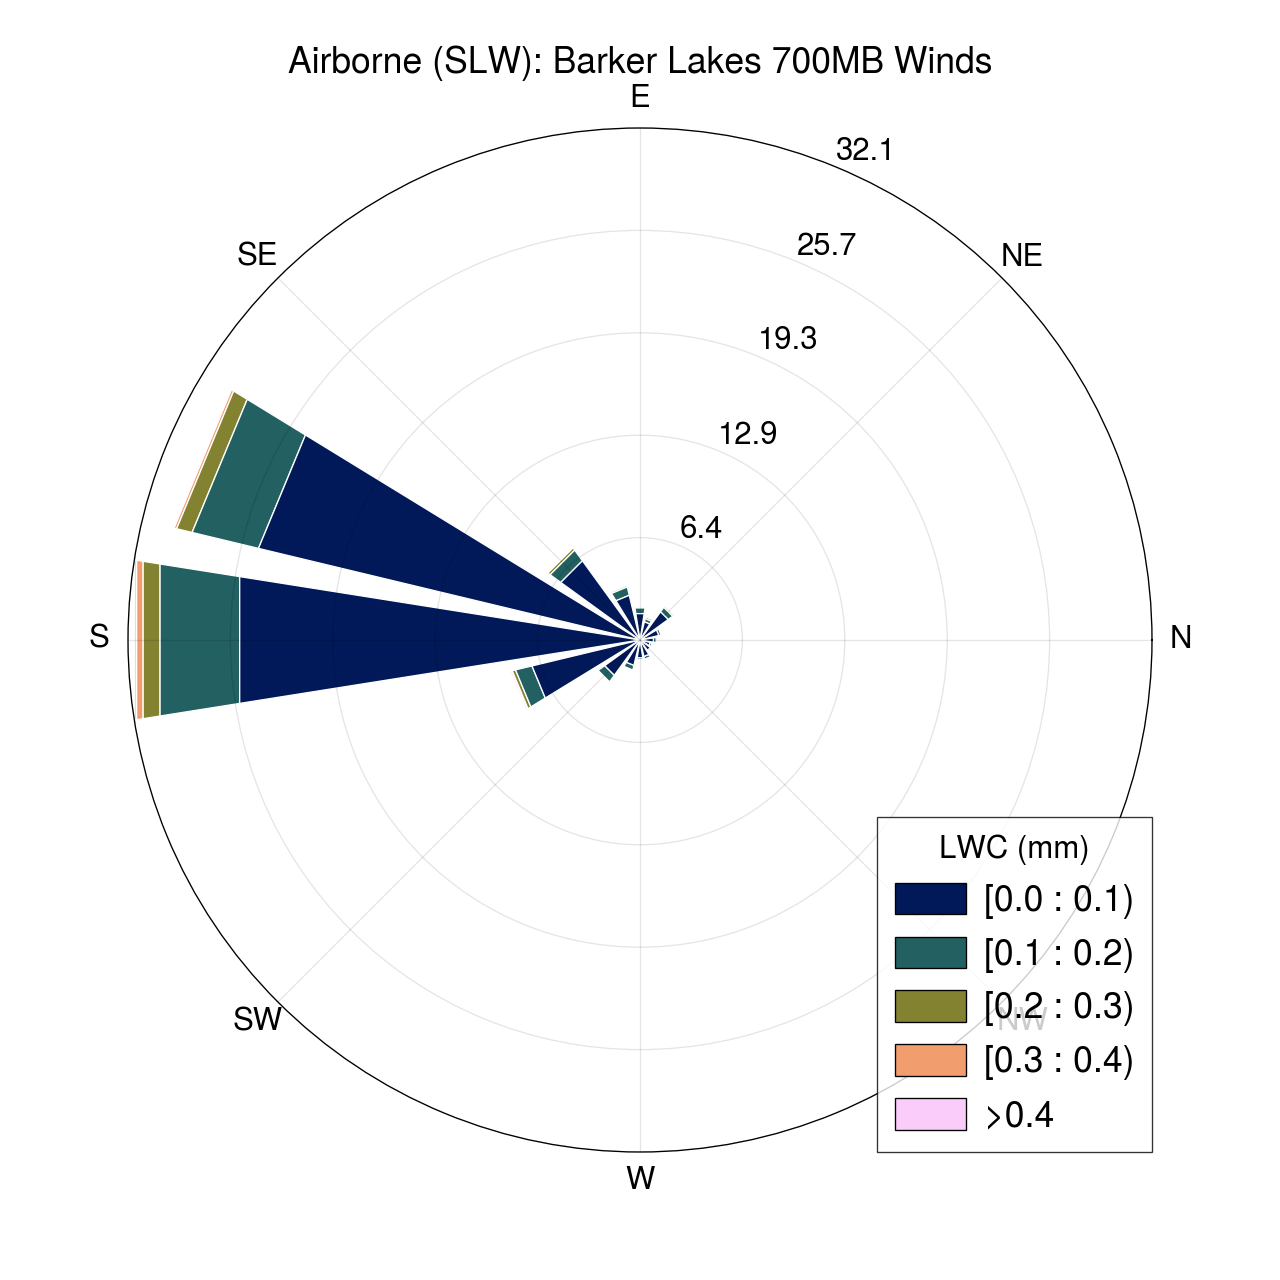

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Basin_Creek_700MB_Winds_Windrose.png"


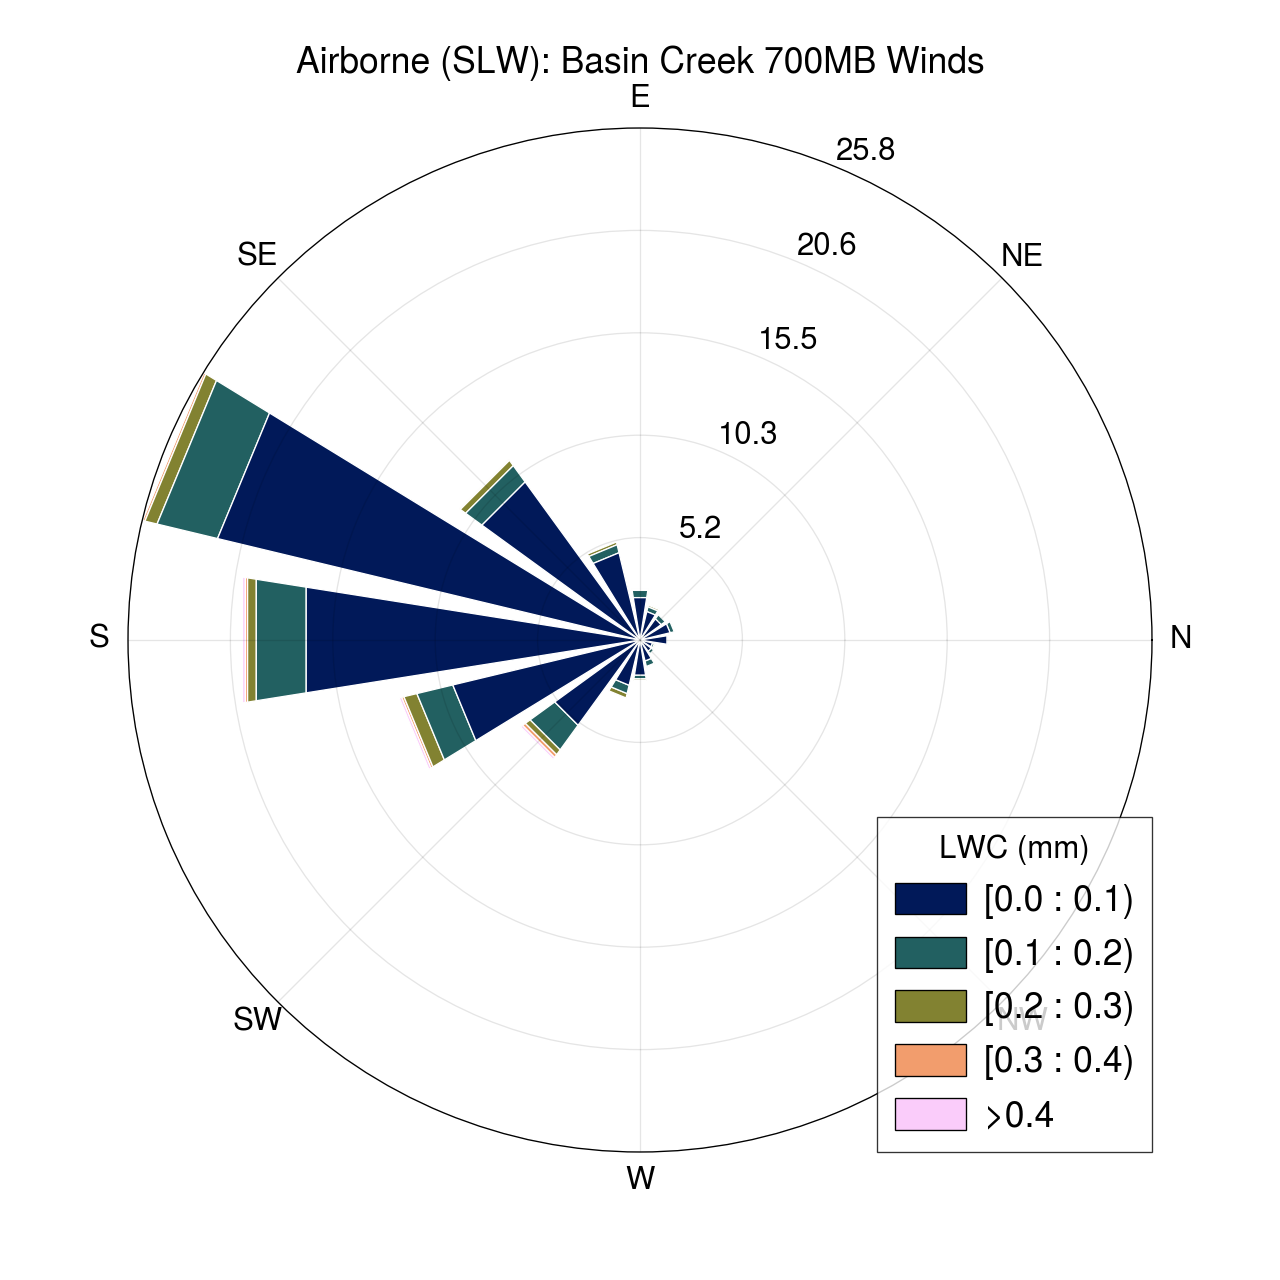

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Calvert_Creek_700MB_Winds_Windrose.png"


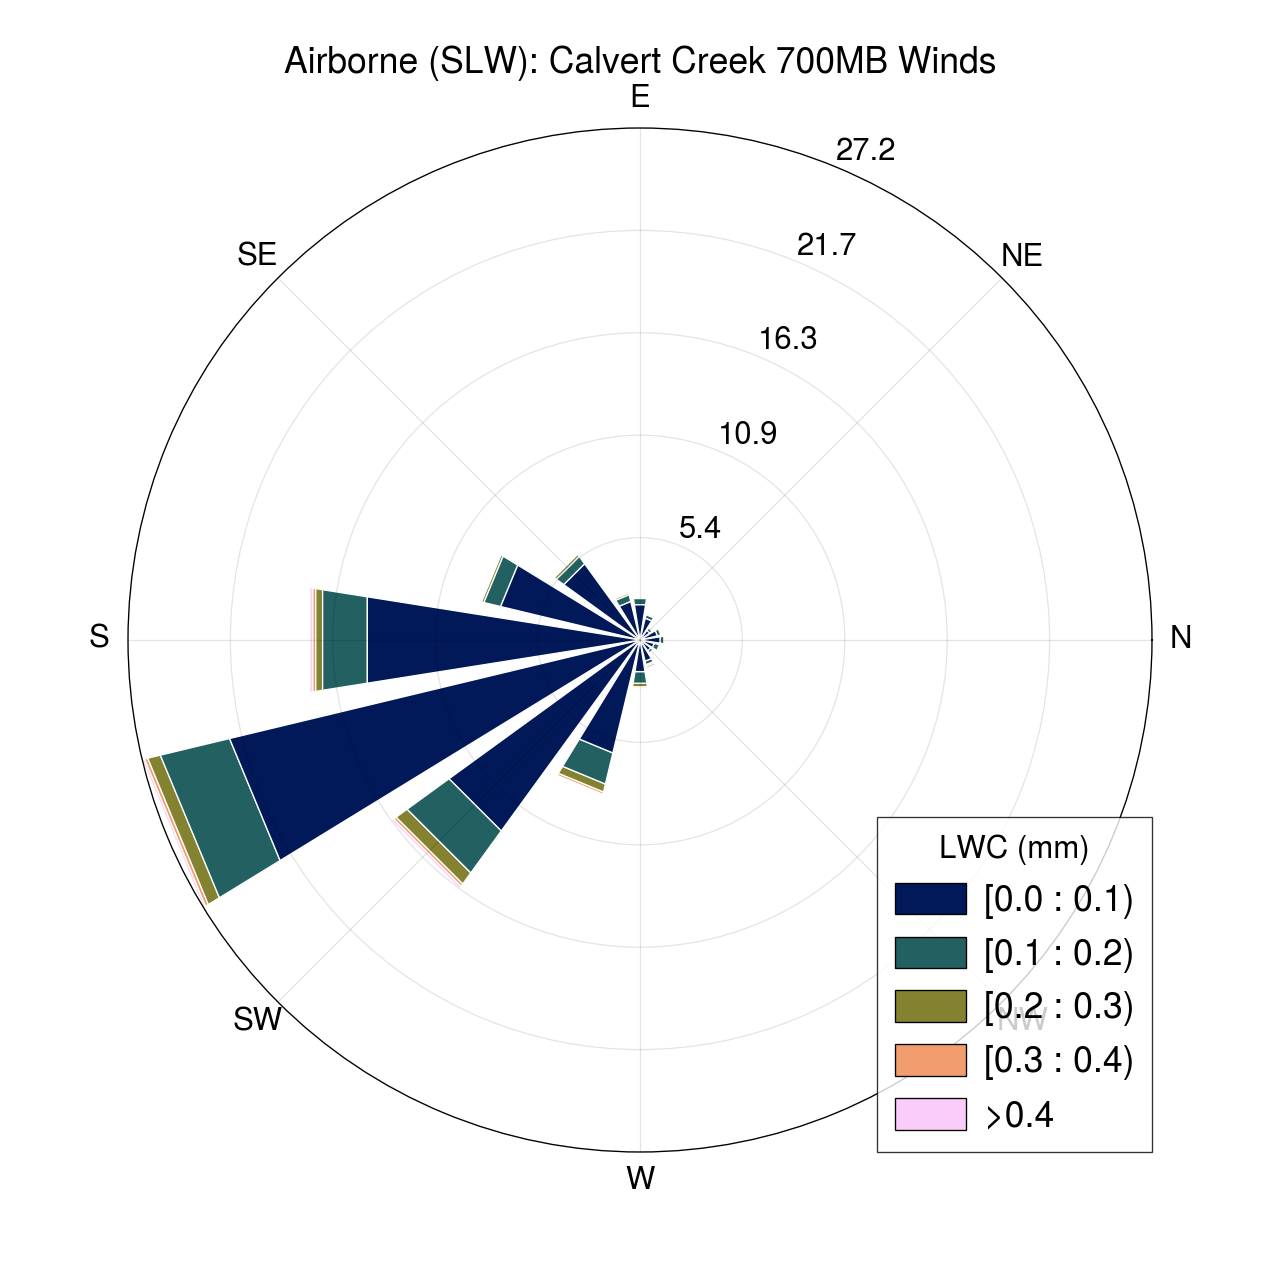

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Dark_Horse_700MB_Winds_Windrose.png"


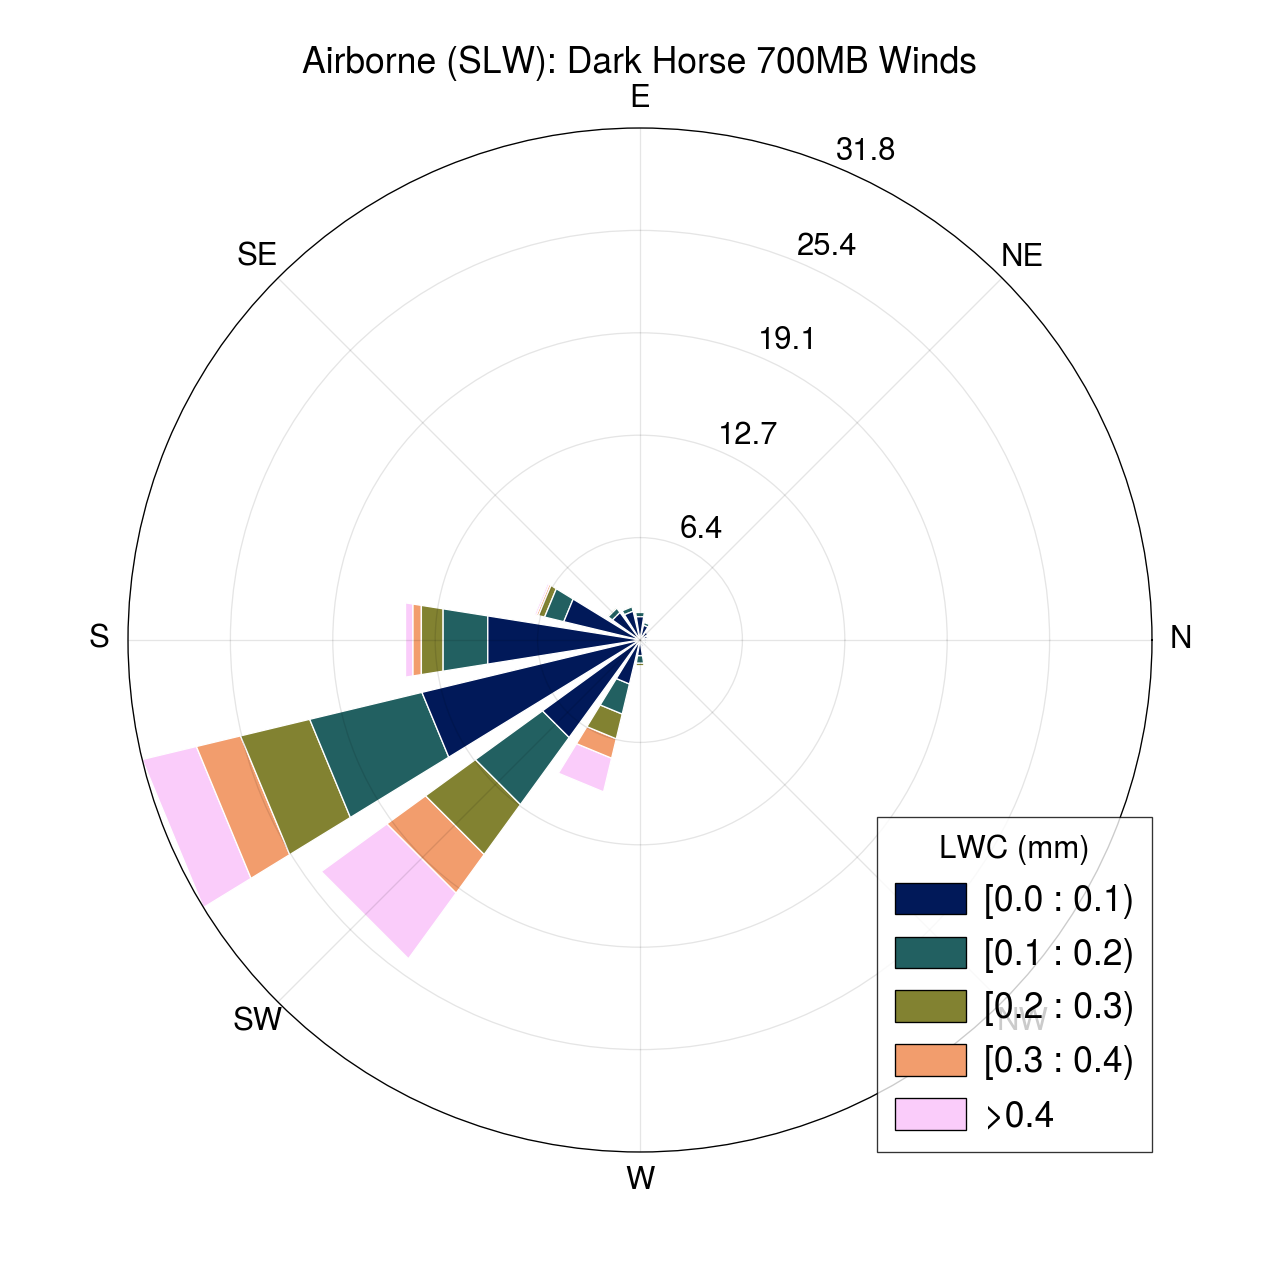

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Lemhi_Ridge_700MB_Winds_Windrose.png"


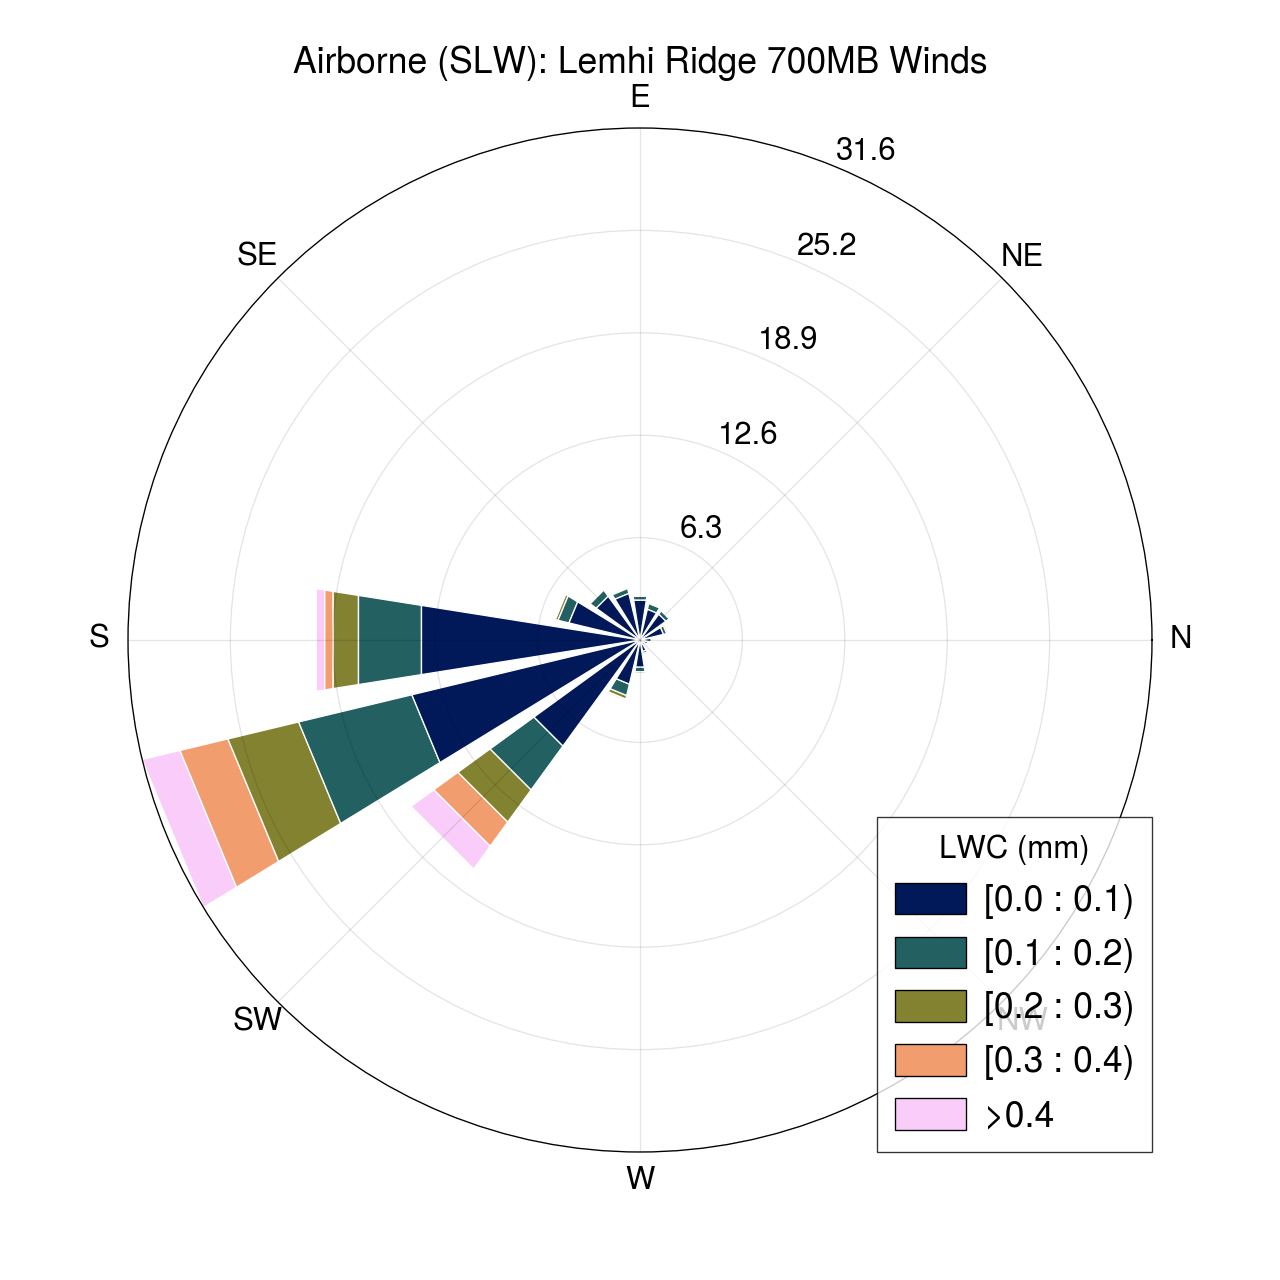

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Mule_Creek_700MB_Winds_Windrose.png"


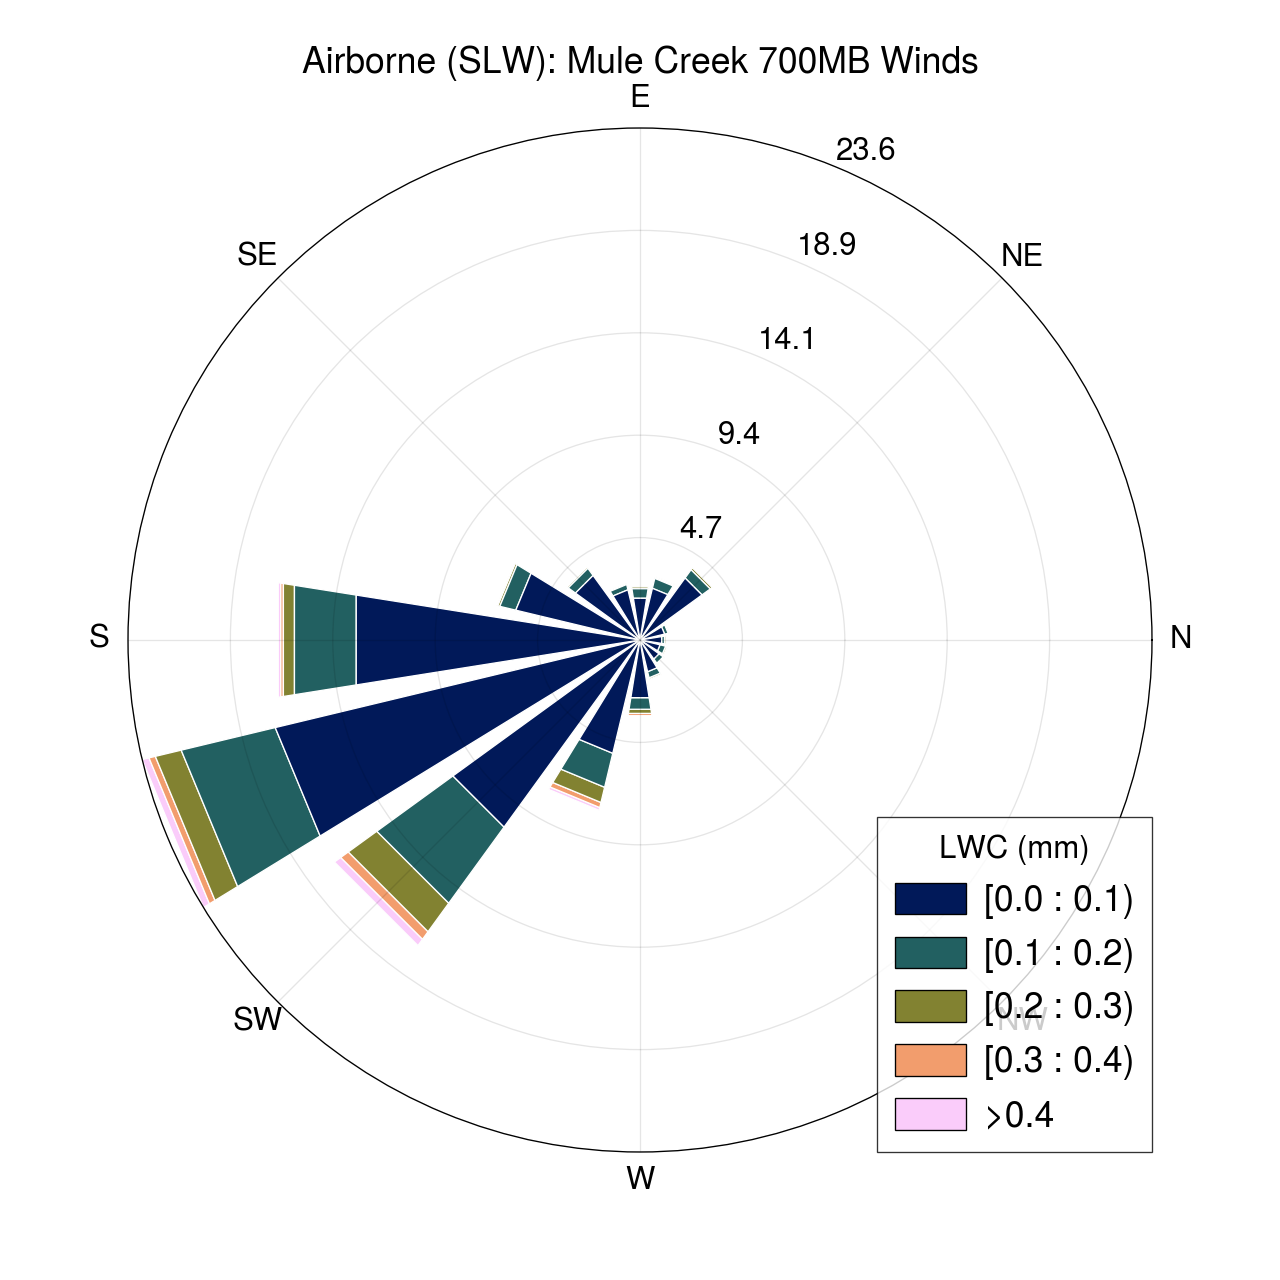

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/airslw_windrose/Airborne_SLW_Saddle_Mountain_700MB_Winds_Windrose.png"


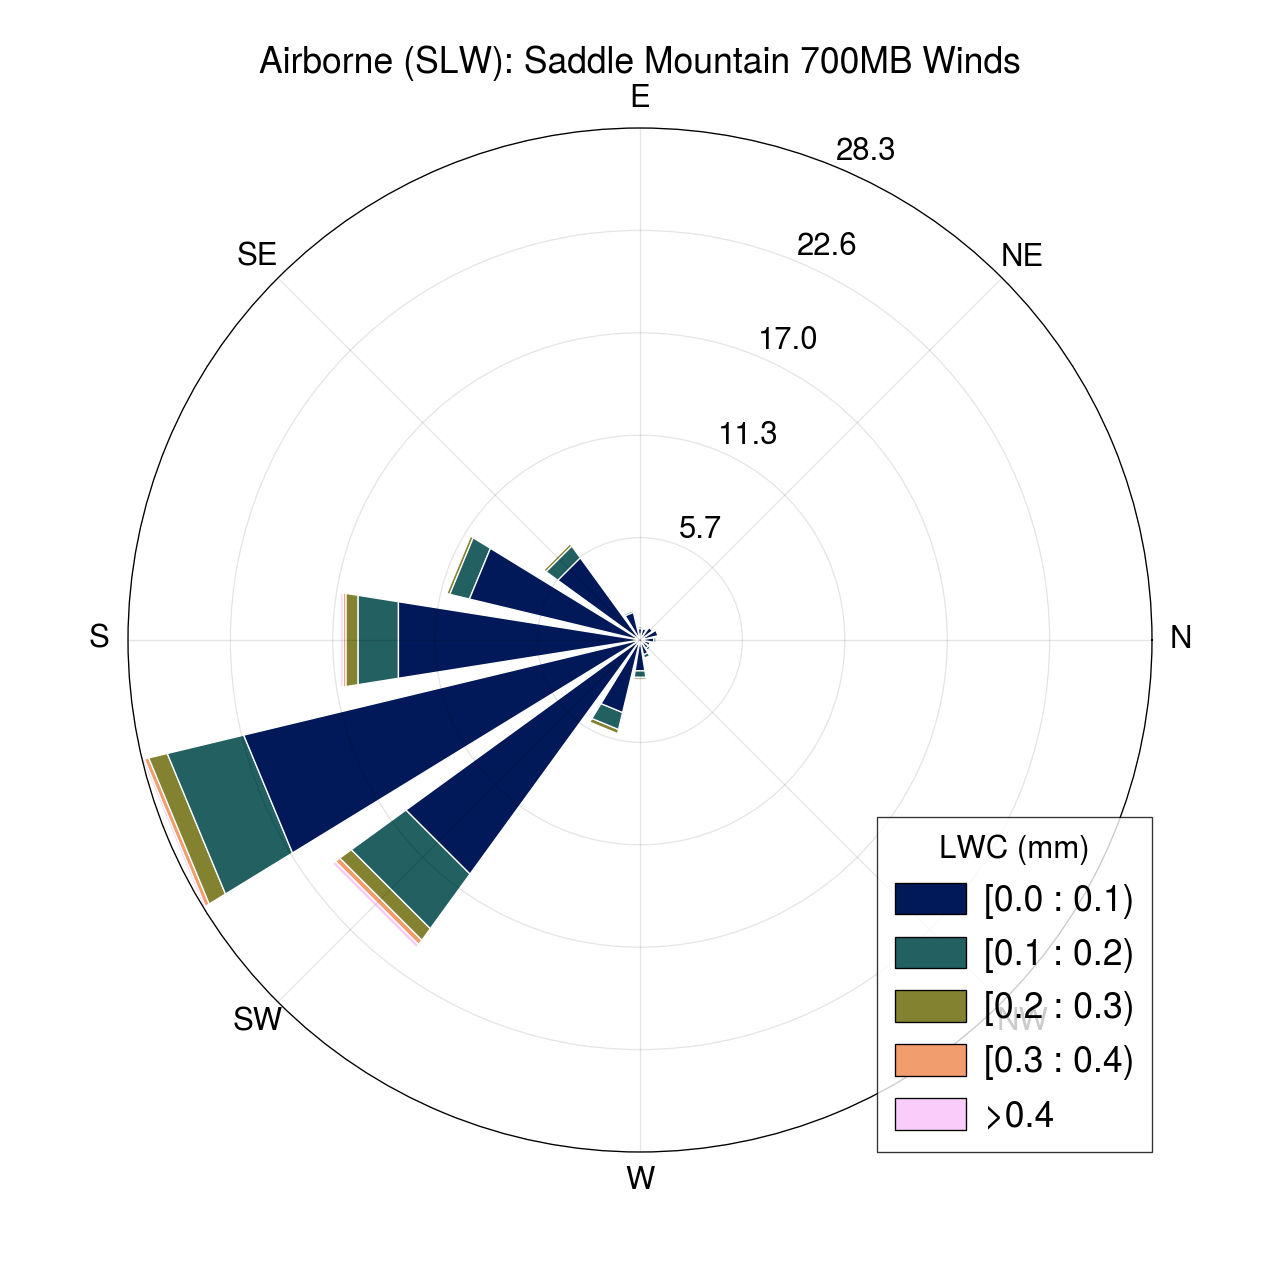

In [21]:
#Plot windroses by SLW - Airborne
def airslw_windrose(filepath=None, name=None):
    filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
    ds = xr.open_dataset(filepath, engine = 'netcdf4')
    df = ds[['U_700MB','V_700MB','AS_LWC']].to_dataframe()
    df=df[df['AS_LWC']>0.01]
    df.U_700MB[df.U_700MB > 999] = np.nan
    df.V_700MB[df.V_700MB > 999] = np.nan
    df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
    df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
    df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    speed =df.WSPD
    dir = df.WDIR
    LWC=df.AS_LWC

    colormap = plt.get_cmap('batlow')
    ax = WindroseAxes.from_ax()
    ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW'],fontsize=14)
    ax.set_yticklabels([],fontsize=14)
    ax.bar(df.WDIR,df.AS_LWC, normed = True, opening=0.8, edgecolor='white', bins = np.arange(0,.5,0.1),cmap = colormap)

    
    ax.set_legend()
    ax.set_title(name, fontsize=16)
    ax.legend(title='LWC (mm)',loc = 4, fontsize=16, title_fontsize=14)

    # ax.set_yticks(np.arange(10, 40, step=10))
    # ax.set_yticklabels(np.arange(10, 40, step=10))
    output_name="{}_Windrose.png".format(name.replace('-','_').replace(':','').replace('(','').replace(')','').replace(' ','_'))
    output_file=os.path.join(output_path, 'airslw_windrose', output_name)
    print(f'Saving windrose image to: "{output_file}"')
    matplotlib.pyplot.savefig(output_file, dpi=300, transparent=False)
    # matplotlib.pyplot.close()
    matplotlib.pyplot.show()
    
_=[airslw_windrose(**dd) for dd in airfiles]



In [ ]:
#Plot windroses by SLW - Airborne - No labels
def SLW_windrose(filepath=None, name=None):
    filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
    ds = xr.open_dataset(filepath, engine = 'netcdf4')
    df = ds[['U_700MB','V_700MB','AS_LWC']].to_dataframe()
    df=df[df['AS_LWC']>0.01]
    df.U_700MB[df.U_700MB > 999] = np.nan
    df.V_700MB[df.V_700MB > 999] = np.nan
    df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
    df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
    df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    speed =df.WSPD
    dir = df.WDIR

    colormap = plt.get_cmap('glacial')
    ax = WindroseAxes.from_ax()
    ax.bar(df.WDIR,df.WSPD, normed = True, opening=0.8, edgecolor='white', bins = 10,cmap = colormap)

    
    #ax.set_legend()
    ax.set_title(name)
    #ax.legend(title='Wind Speed (m/s)) with SLW - Airborne',loc = 4)

    # ax.set_yticks(np.arange(10, 40, step=10))
    # ax.set_yticklabels(np.arange(10, 40, step=10))

    #matplotlib.pyplot.savefig(os.path.join('precip_windrose',"{} Precip Windrose.png".format(name.replace(' ','_'))), dpi=300, transparent=False)
    #matplotlib.pyplot.close()
    matplotlib.pyplot.show()
    
_=[SLW_windrose(**dd) for dd in files]



Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Barker_Lakes_700MB_Winds_Windrose.png"


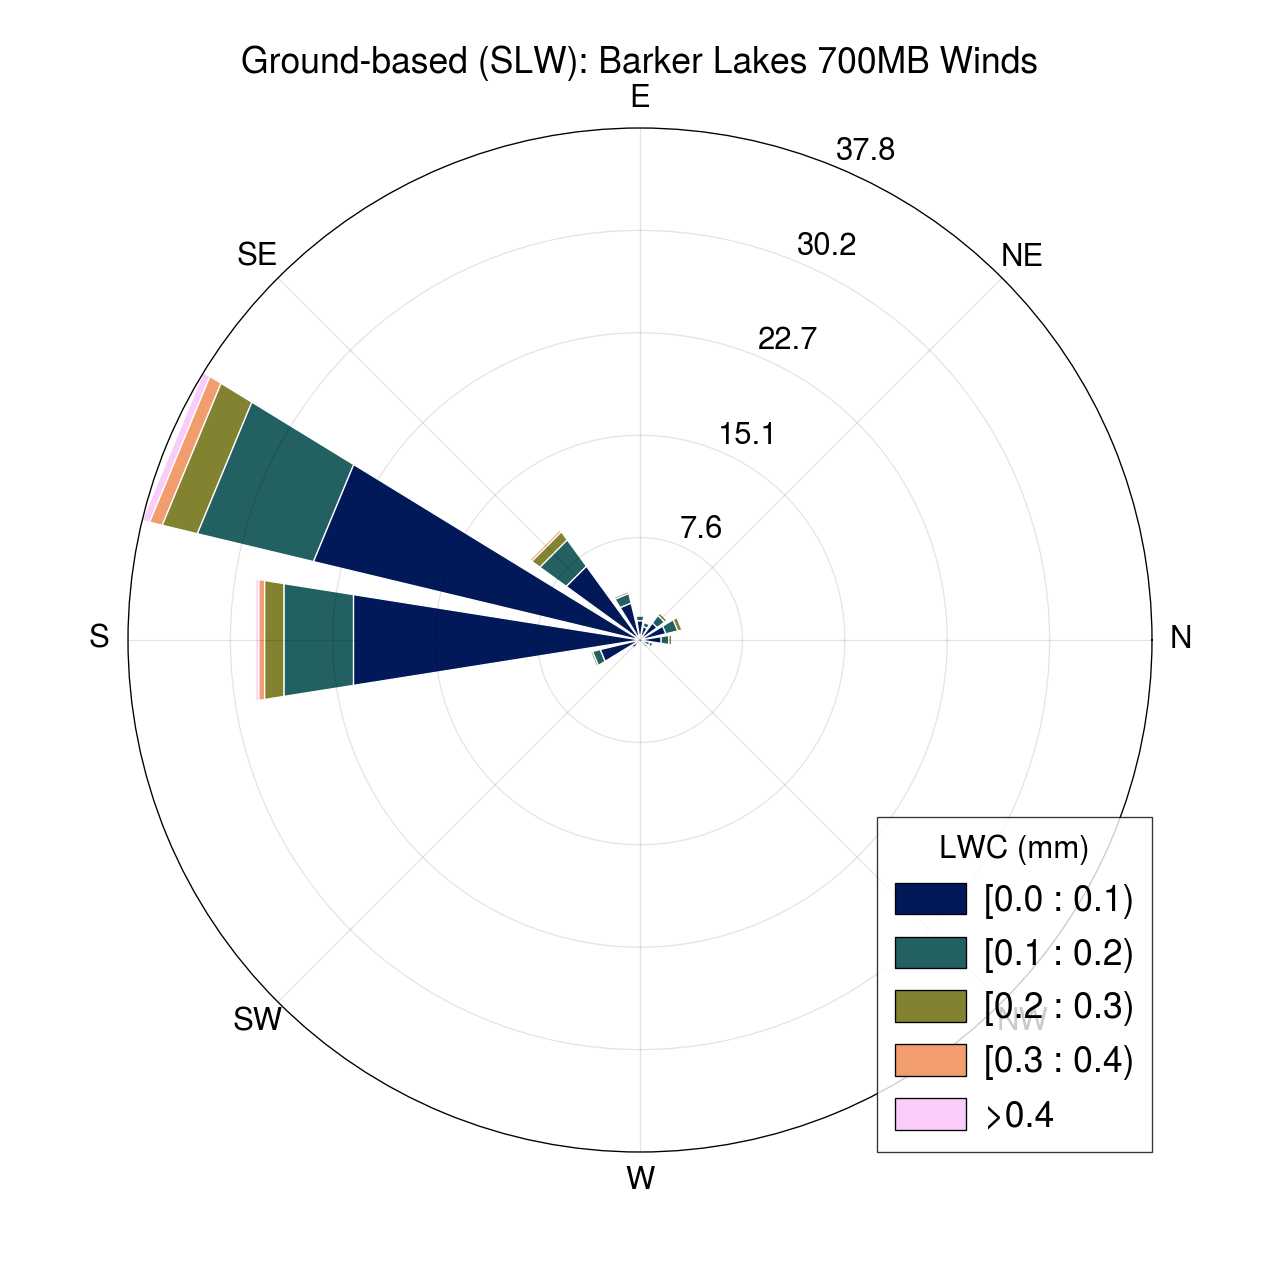

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Basin_Creek_700MB_Winds_Windrose.png"


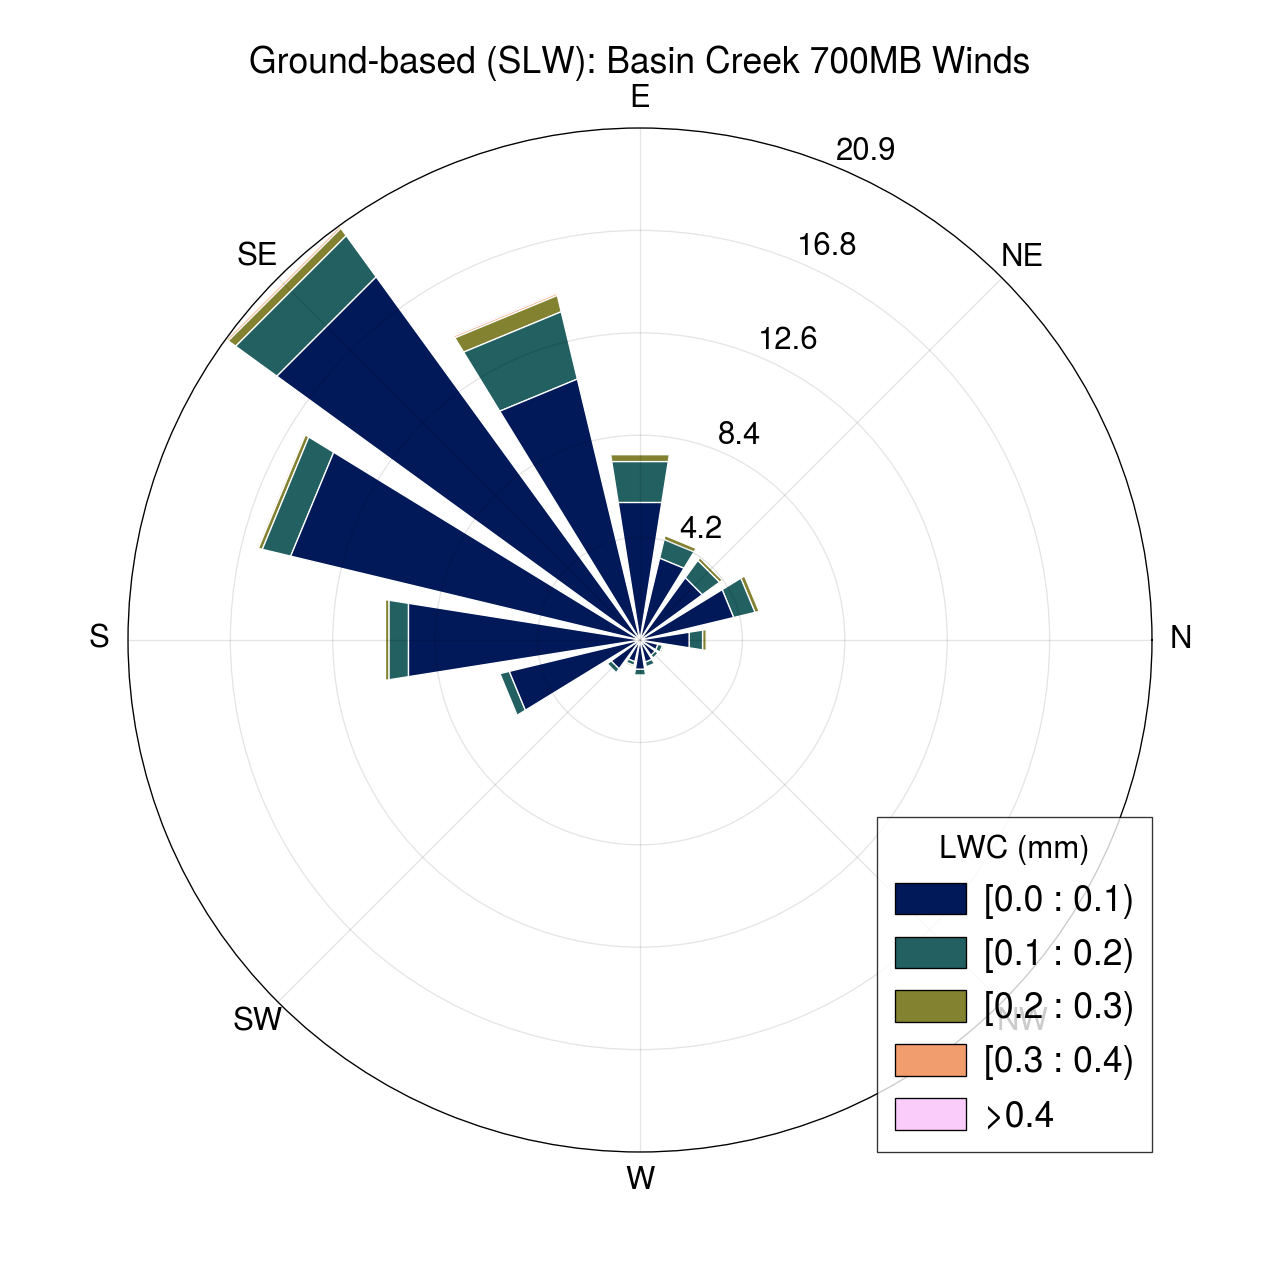

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Calvert_Creek_700MB_Winds_Windrose.png"


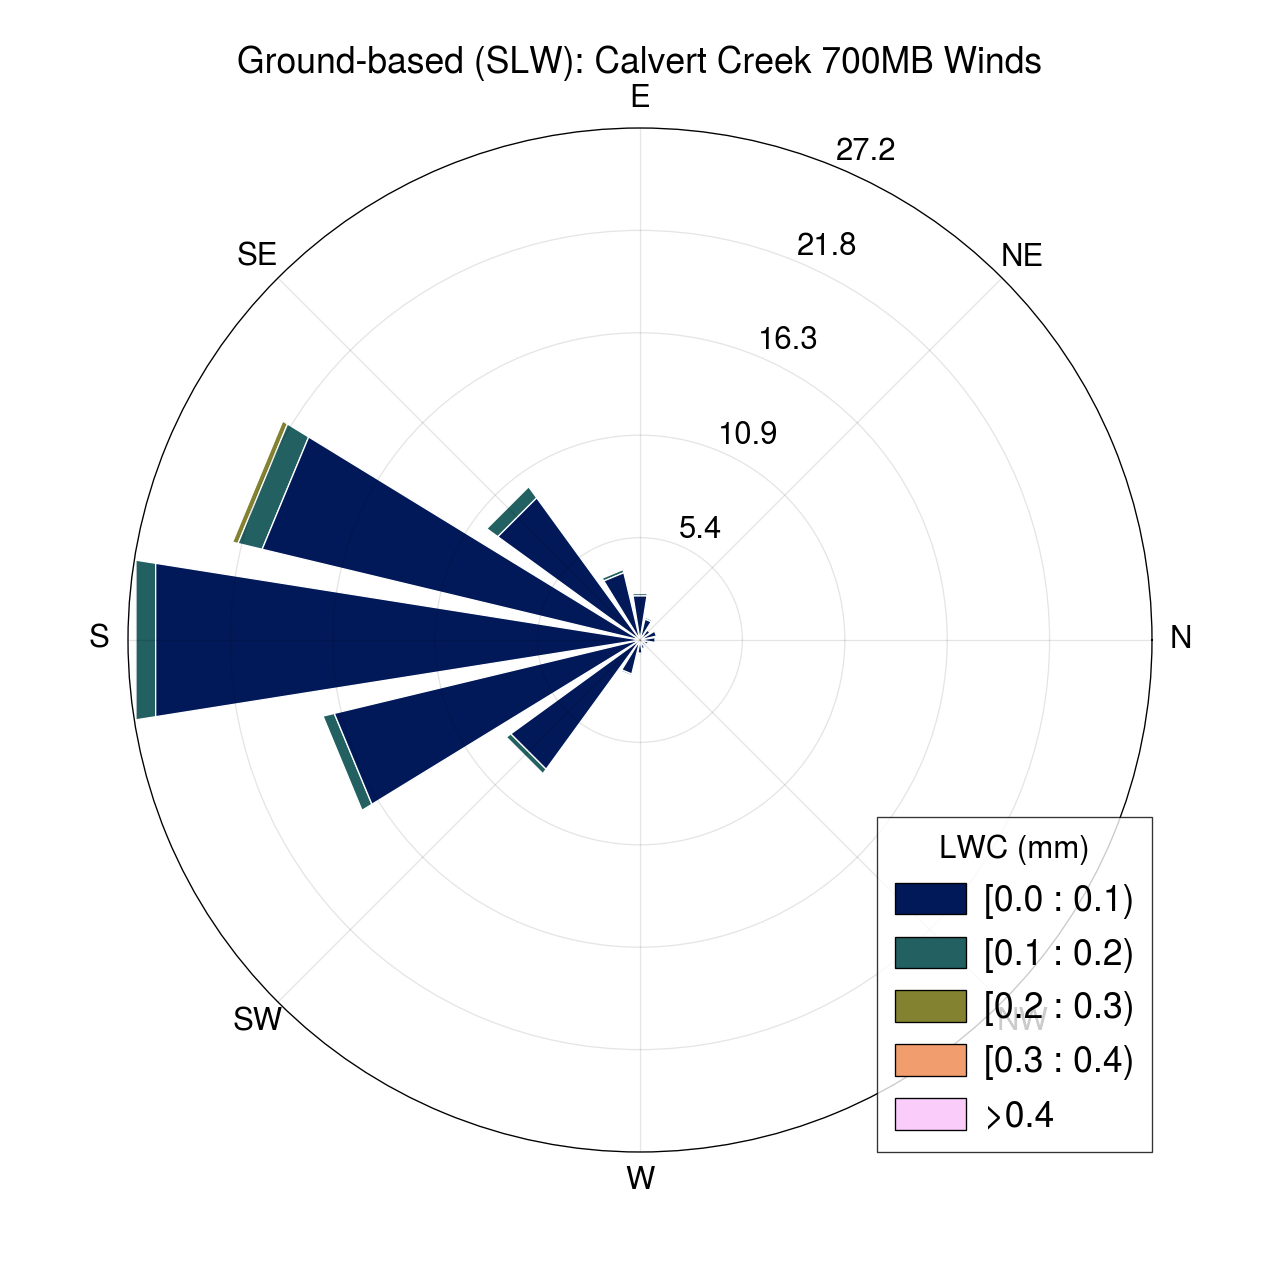

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Dark_Horse_700MB_Winds_Windrose.png"


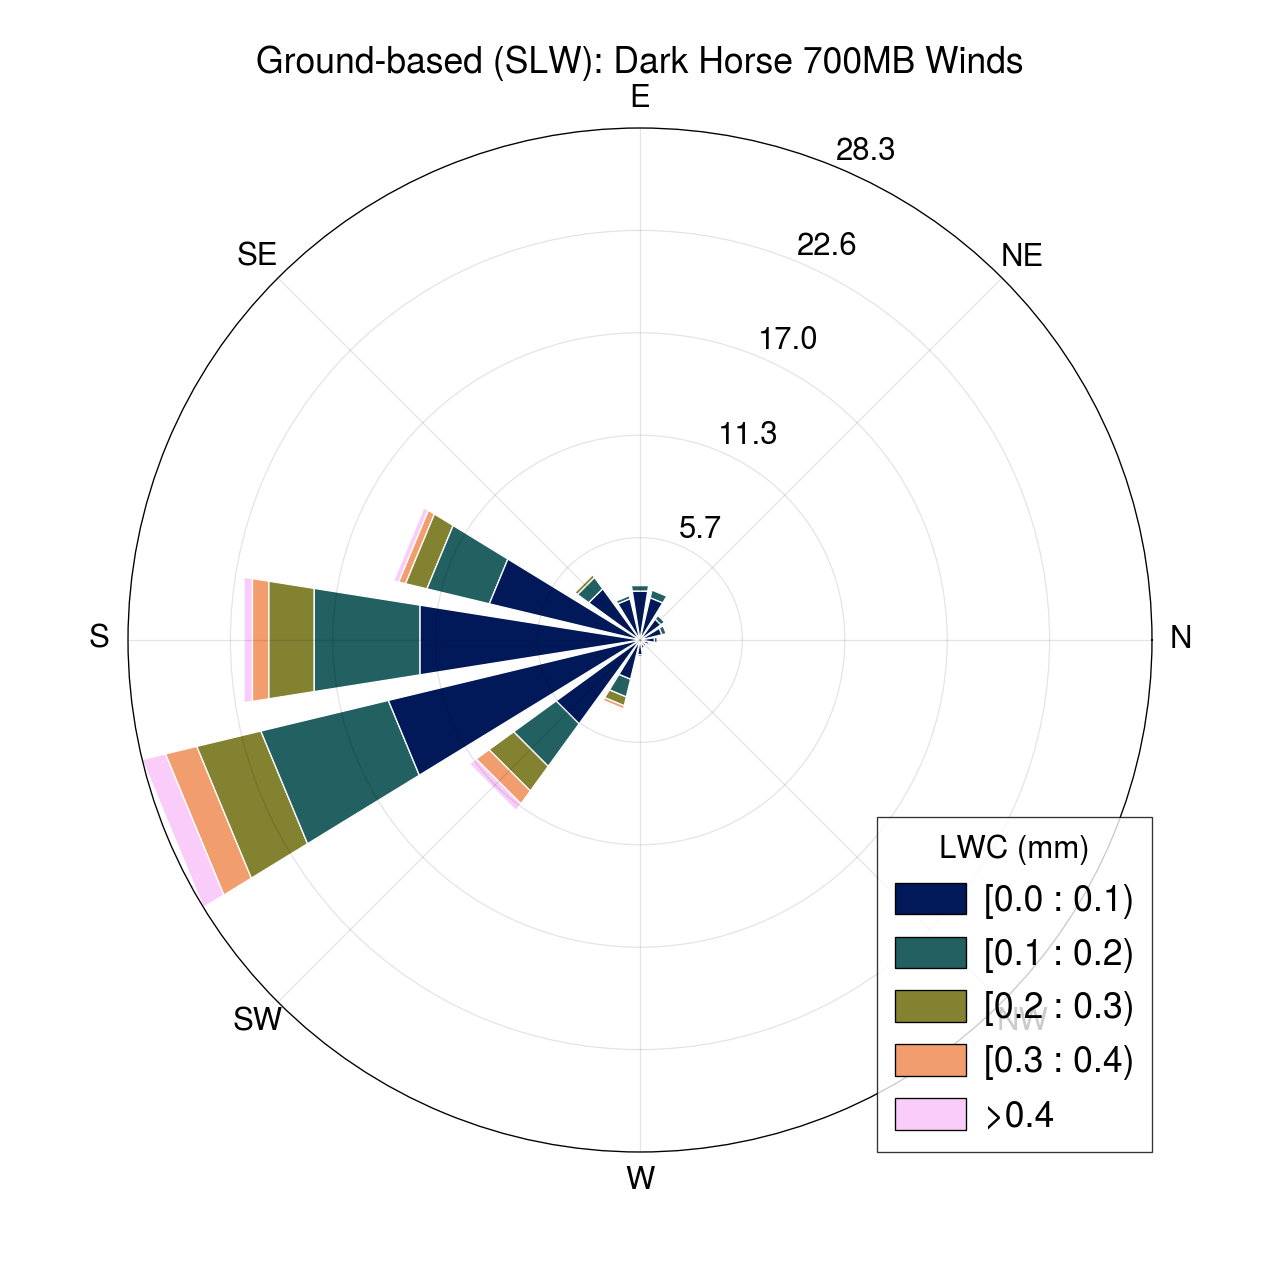

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Lemhi_Ridge_700MB_Winds_Windrose.png"


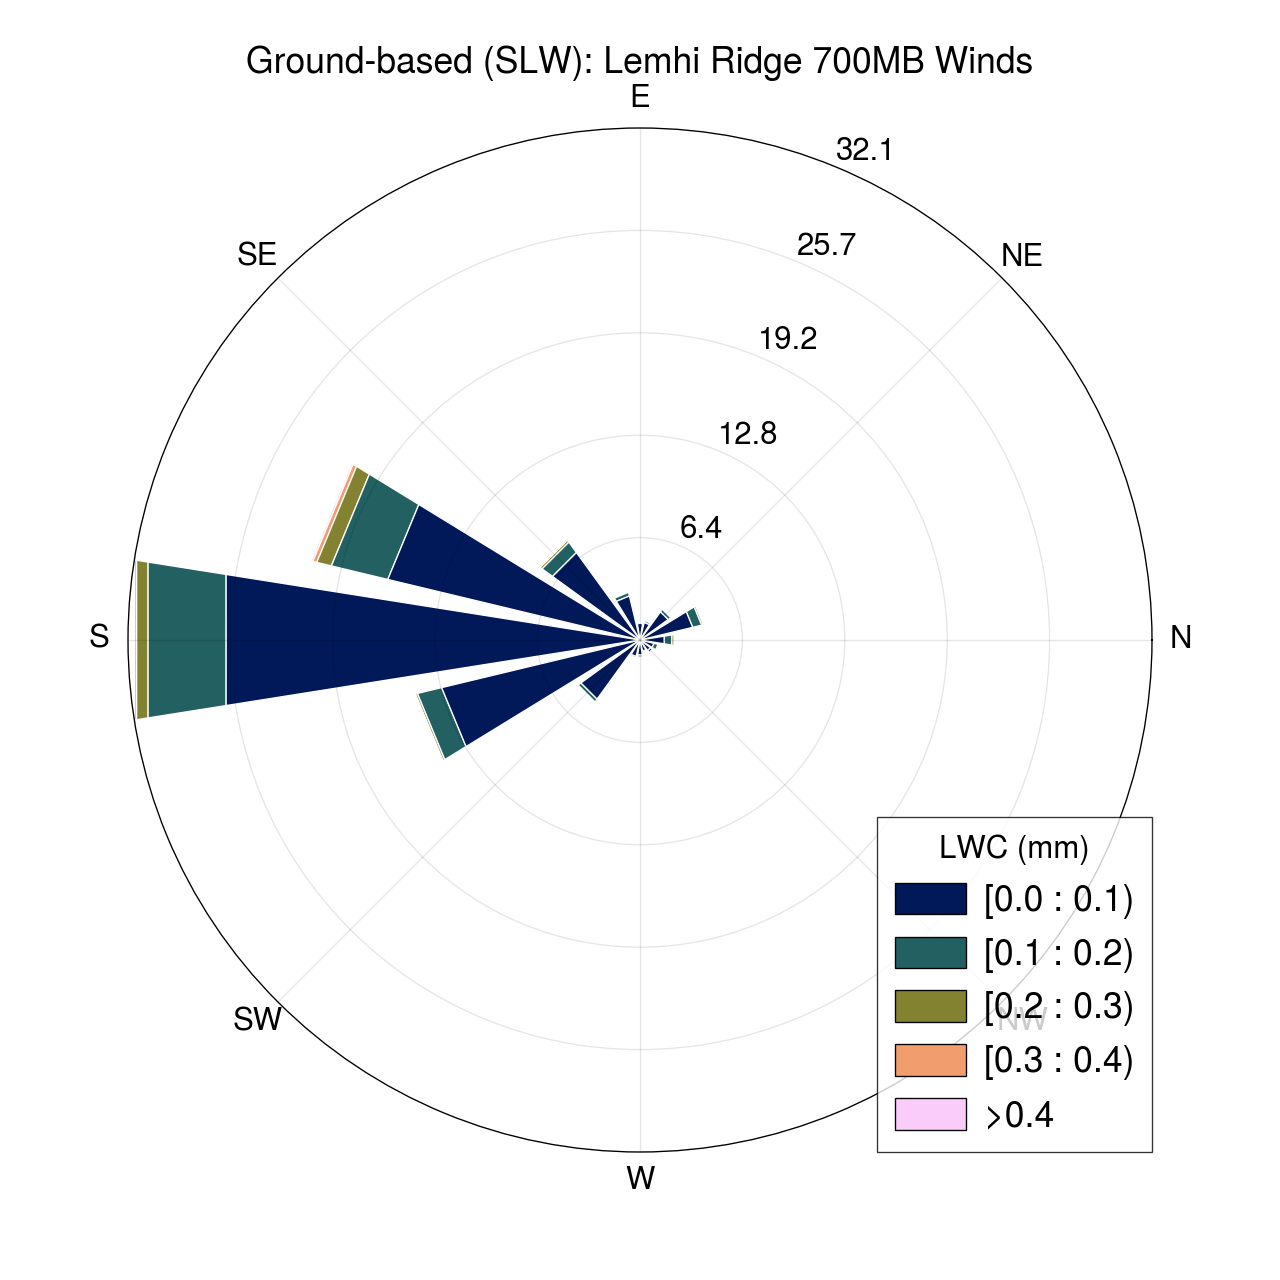

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Mule_Creek_700MB_Winds_Windrose.png"


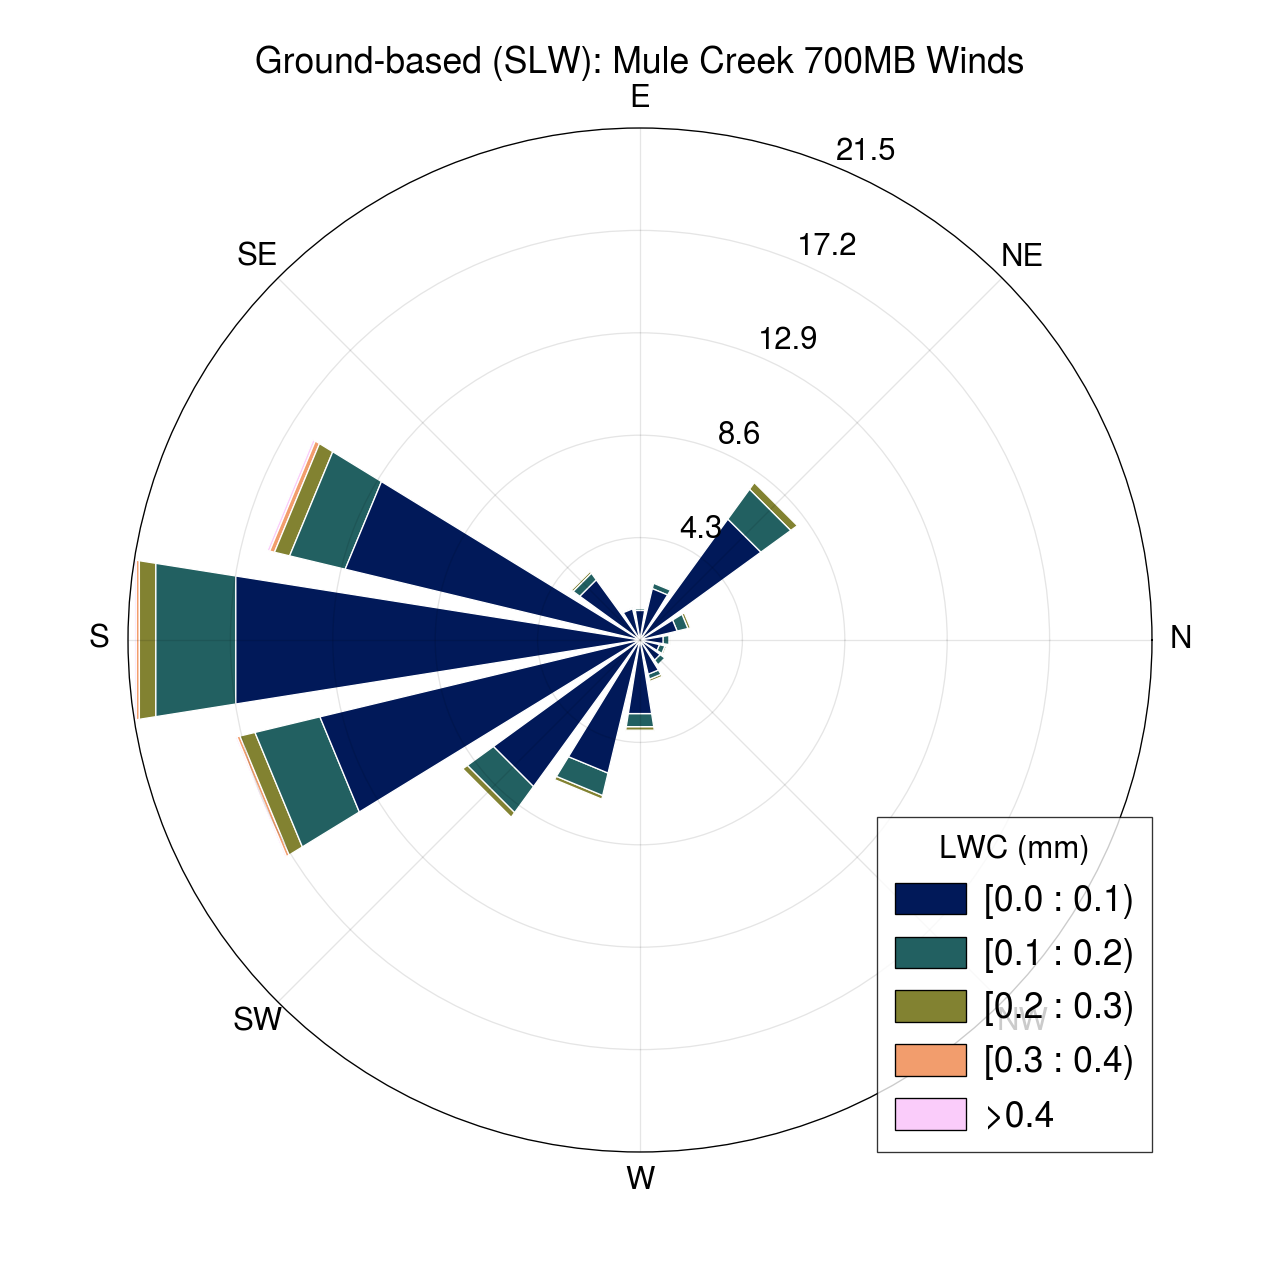

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/groundslw_windrose/Ground_based_SLW_Saddle_Mountain_700MB_Winds_Windrose.png"


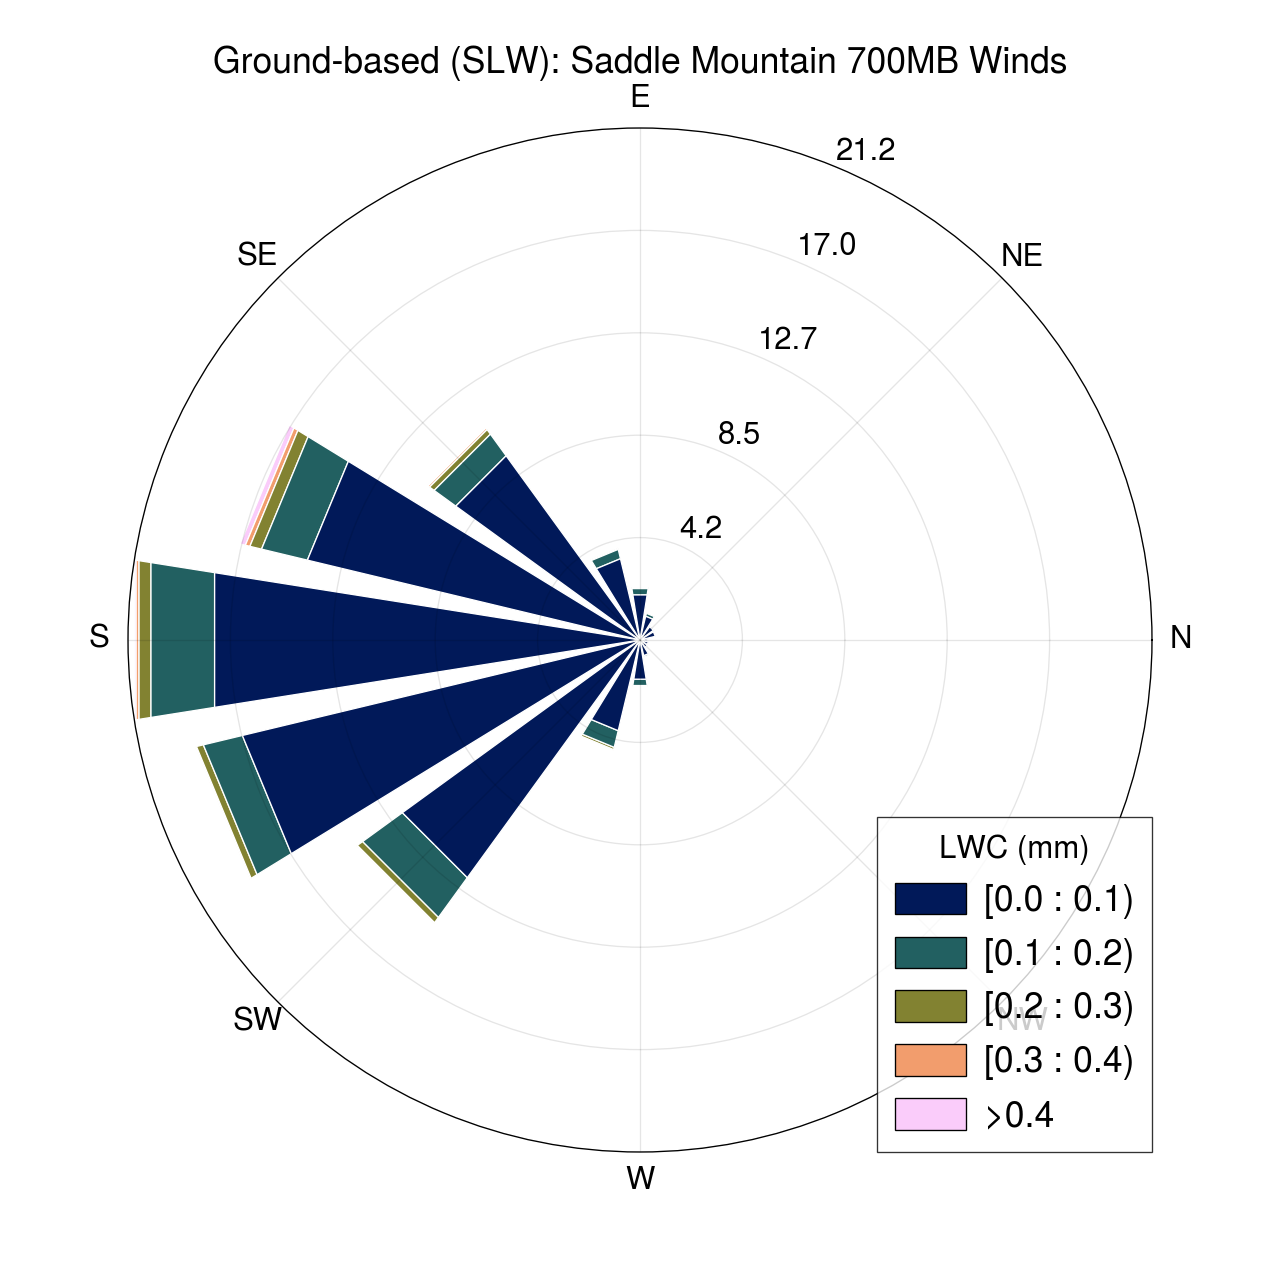

In [23]:
#Plot windroses by SLW - Ground 
def groundslw_windrose(filepath=None, name=None):
    filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
    ds = xr.open_dataset(filepath, engine = 'netcdf4')
    df = ds[['U_700MB','V_700MB','GS_LWC']].to_dataframe()
    df=df[df['GS_LWC']>0.01]
    df.U_700MB[df.U_700MB > 999] = np.nan
    df.V_700MB[df.V_700MB > 999] = np.nan
    df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
    df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
    df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    speed =df.WSPD
    dir = df.WDIR

    colormap = plt.get_cmap('batlow')
    ax = WindroseAxes.from_ax()
    ax.set_xticklabels(['N','NE','E','SE','S','SW','W','NW'],fontsize=14)
    ax.set_yticklabels([],fontsize=14)
    ax.bar(df.WDIR,df.GS_LWC, normed = True, opening=0.8, edgecolor='white', bins = np.arange(0,.5,0.1),cmap = colormap)

    
    ax.set_legend()
    ax.set_title(name,fontsize=16)
    ax.legend(title='LWC (mm)',loc = 4, fontsize=16, title_fontsize=14)

    # ax.set_yticks(np.arange(10, 40, step=10))
    # ax.set_yticklabels(np.arange(10, 40, step=10))

    #matplotlib.pyplot.savefig(os.path.join('precip_windrose',"{} Precip Windrose.png".format(name.replace(' ','_'))), dpi=300, transparent=False)
    #matplotlib.pyplot.close()
    output_name="{}_Windrose.png".format(name.replace('-','_').replace(':','').replace('(','').replace(')','').replace(' ','_'))
    output_file=os.path.join(output_path, 'groundslw_windrose', output_name)
    print(f'Saving windrose image to: "{output_file}"')
    matplotlib.pyplot.savefig(output_file, dpi=300, transparent=False)
    matplotlib.pyplot.show()
    
_=[groundslw_windrose(**dd) for dd in groundfiles]



Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Barker_Lakes_700MB_Winds_Windrose.png"


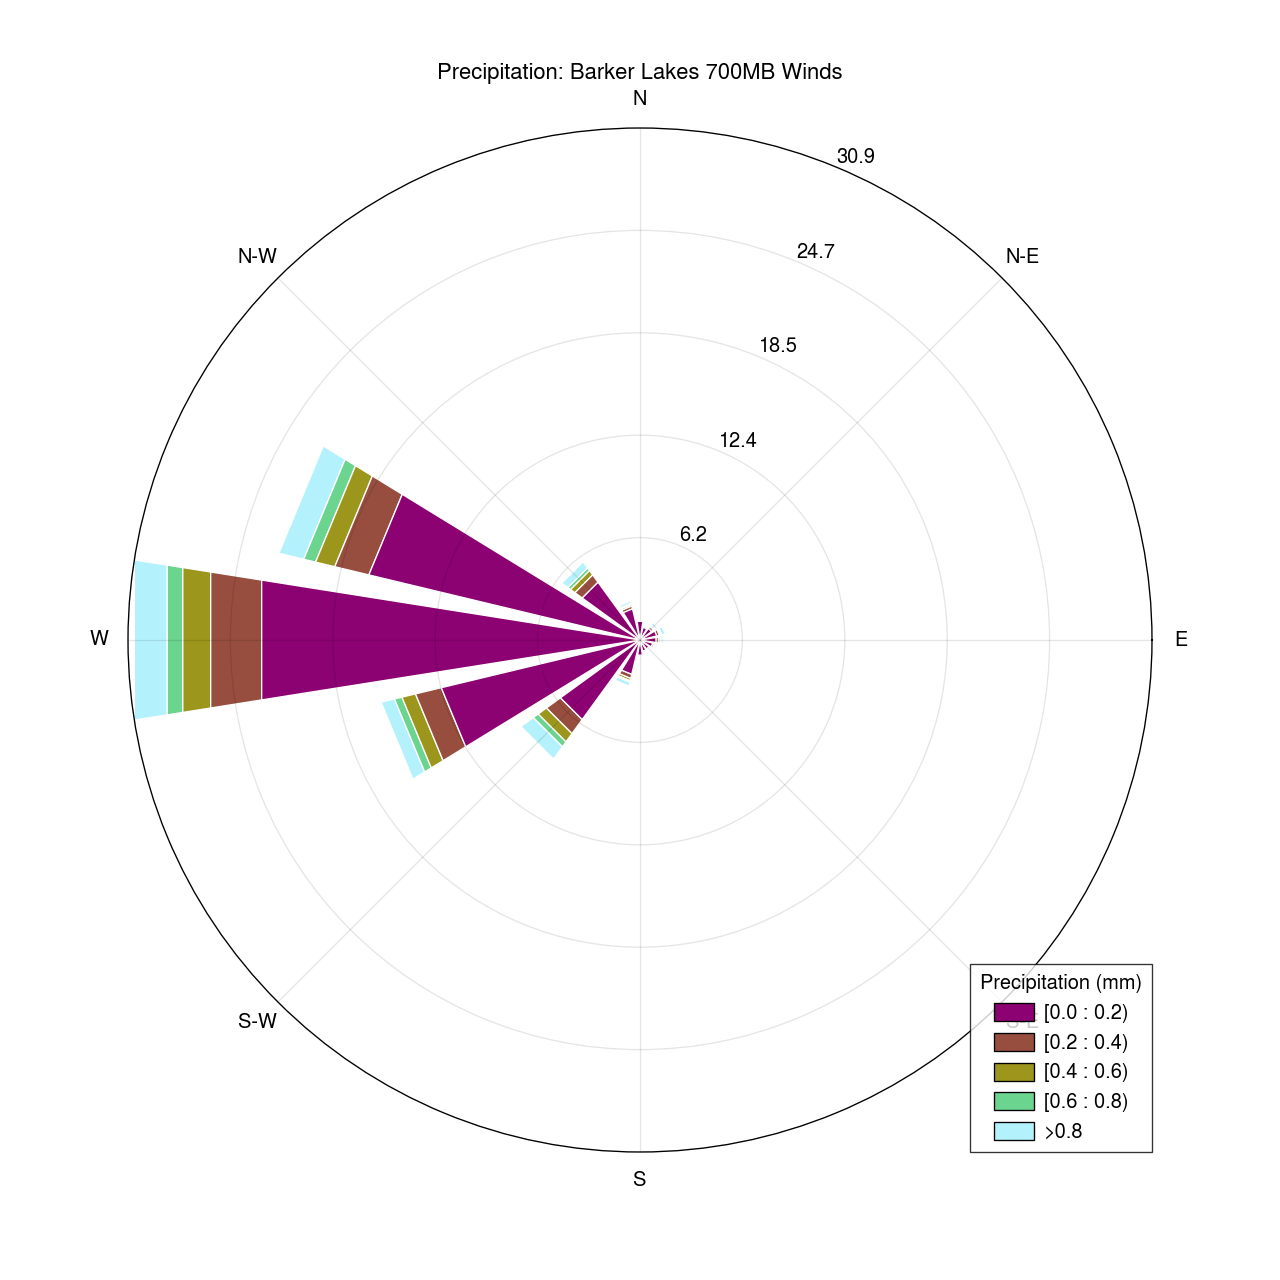

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Basin_Creek_700MB_Winds_Windrose.png"


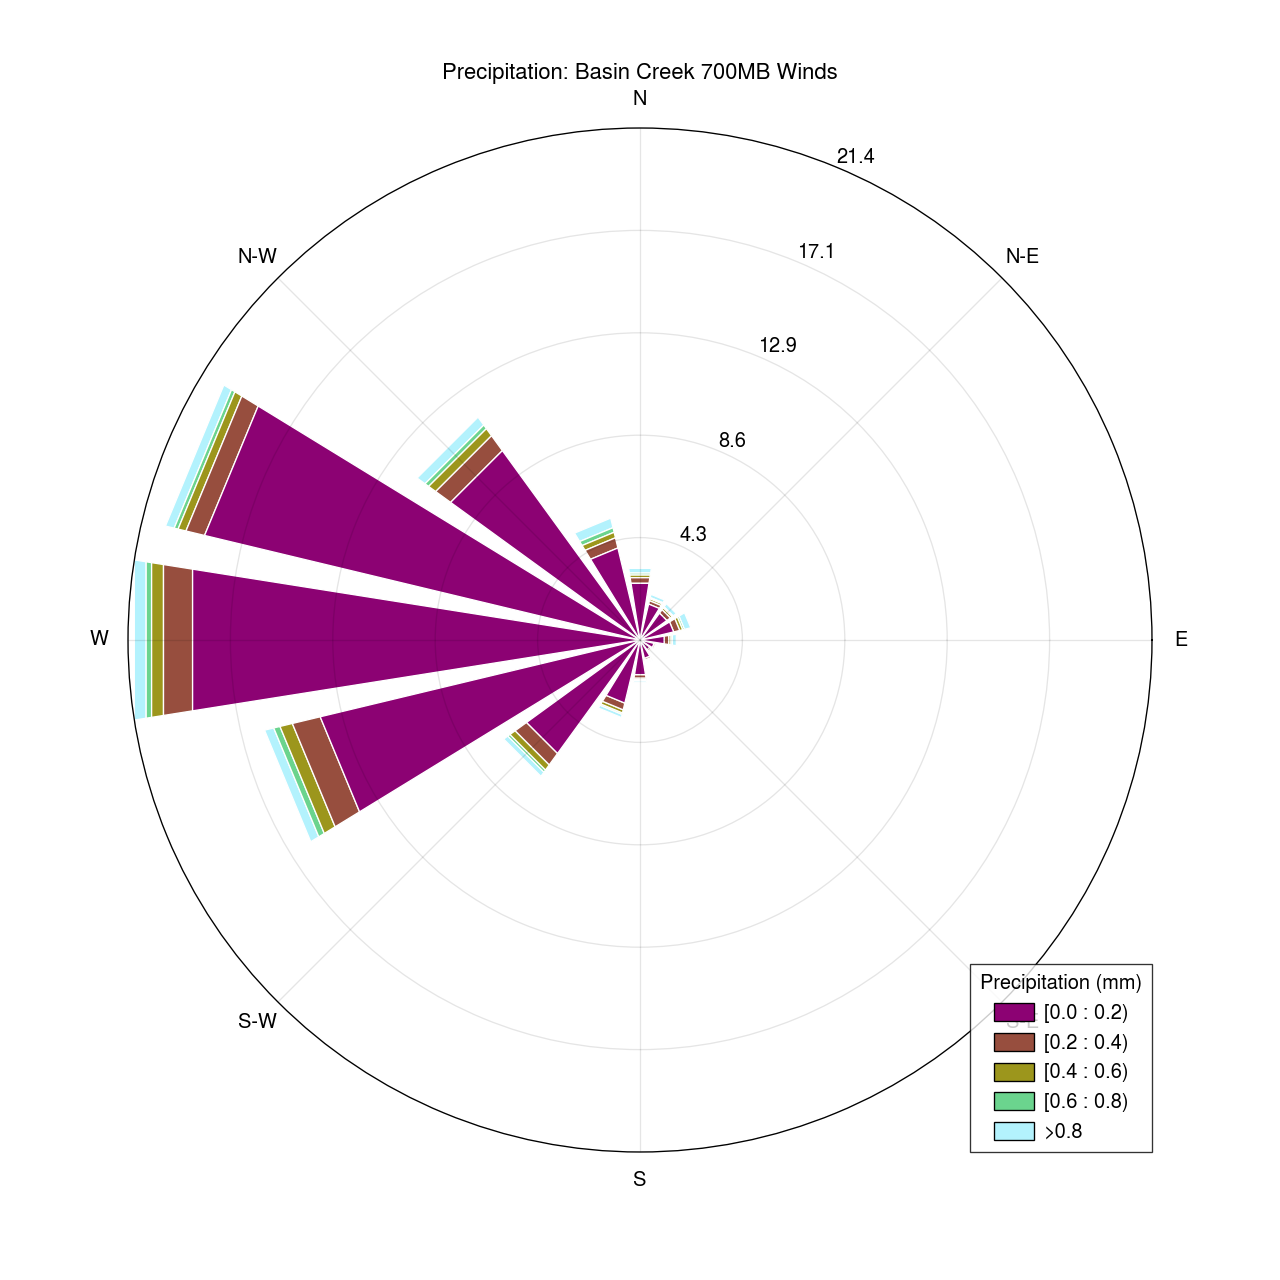

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Calvert_Creek_700MB_Winds_Windrose.png"


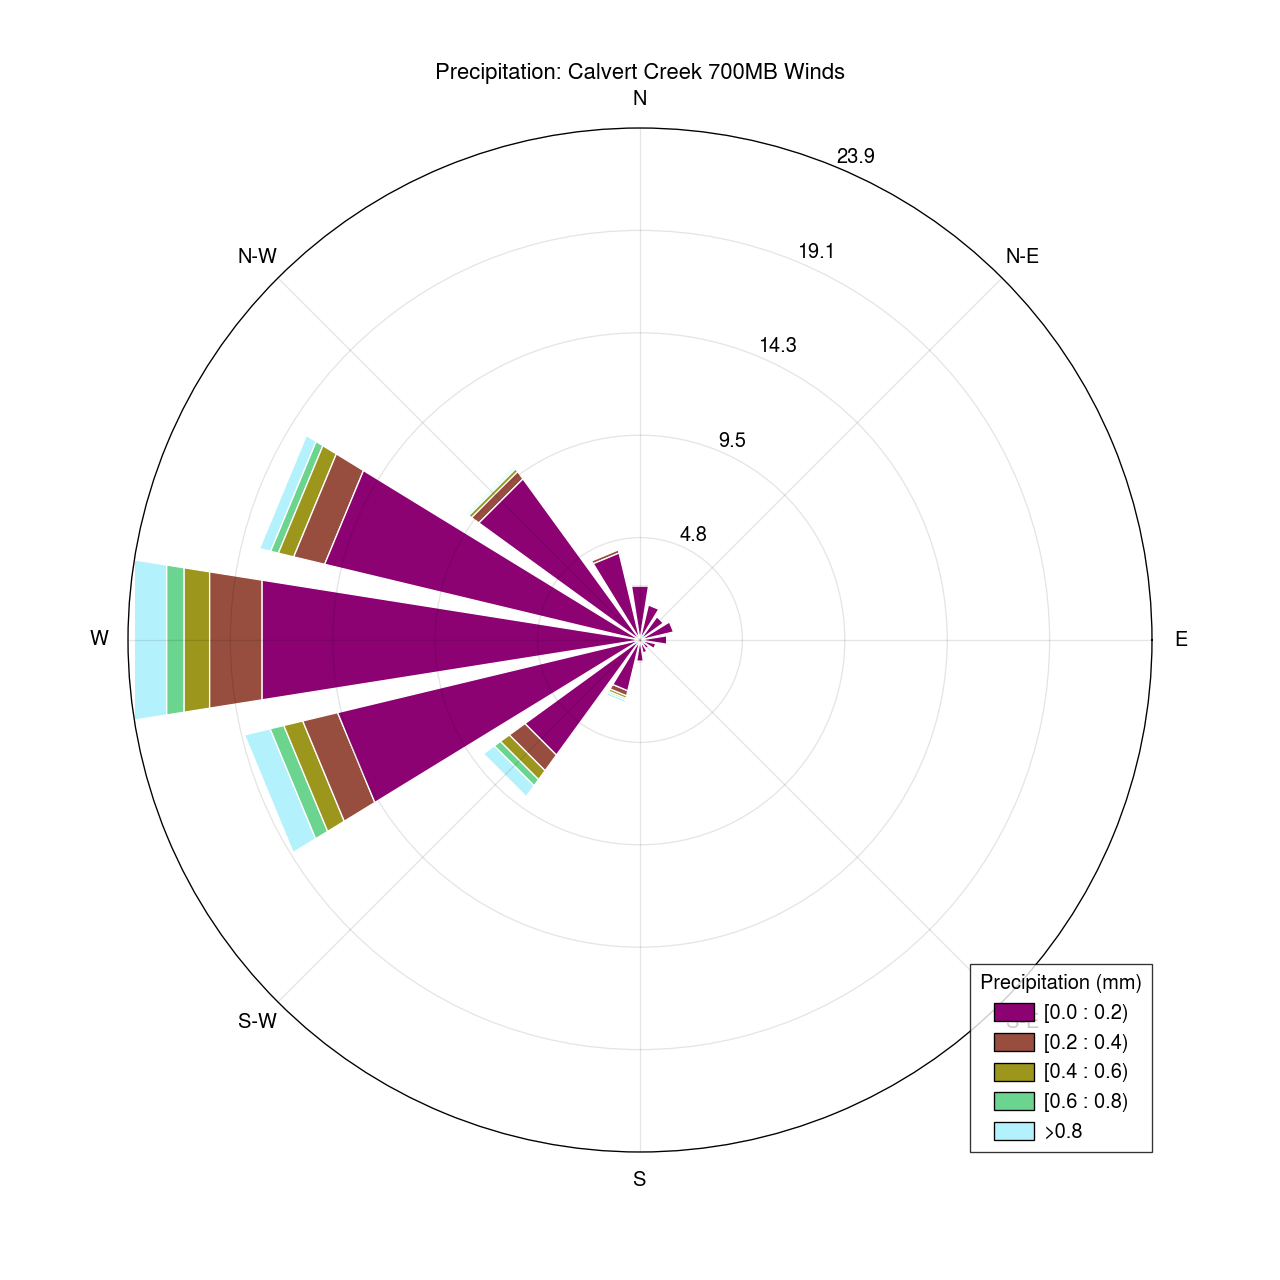

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Dark_Horse_700MB_Winds_Windrose.png"


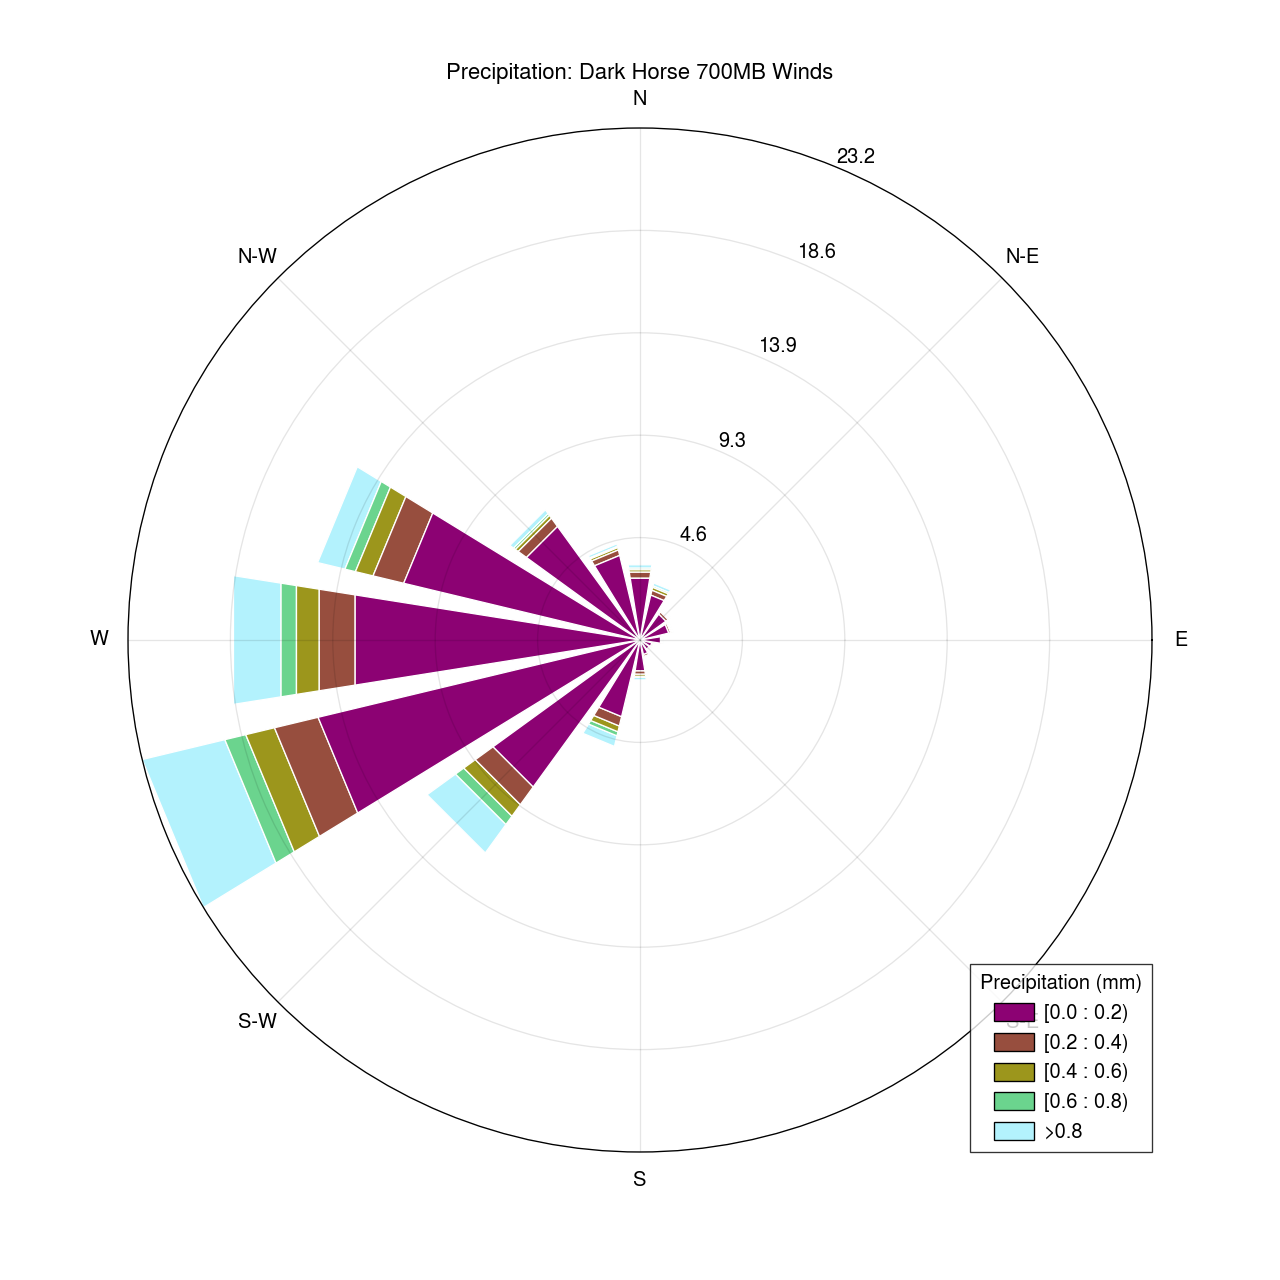

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Lemhi_Ridge_700MB_Winds_Windrose.png"


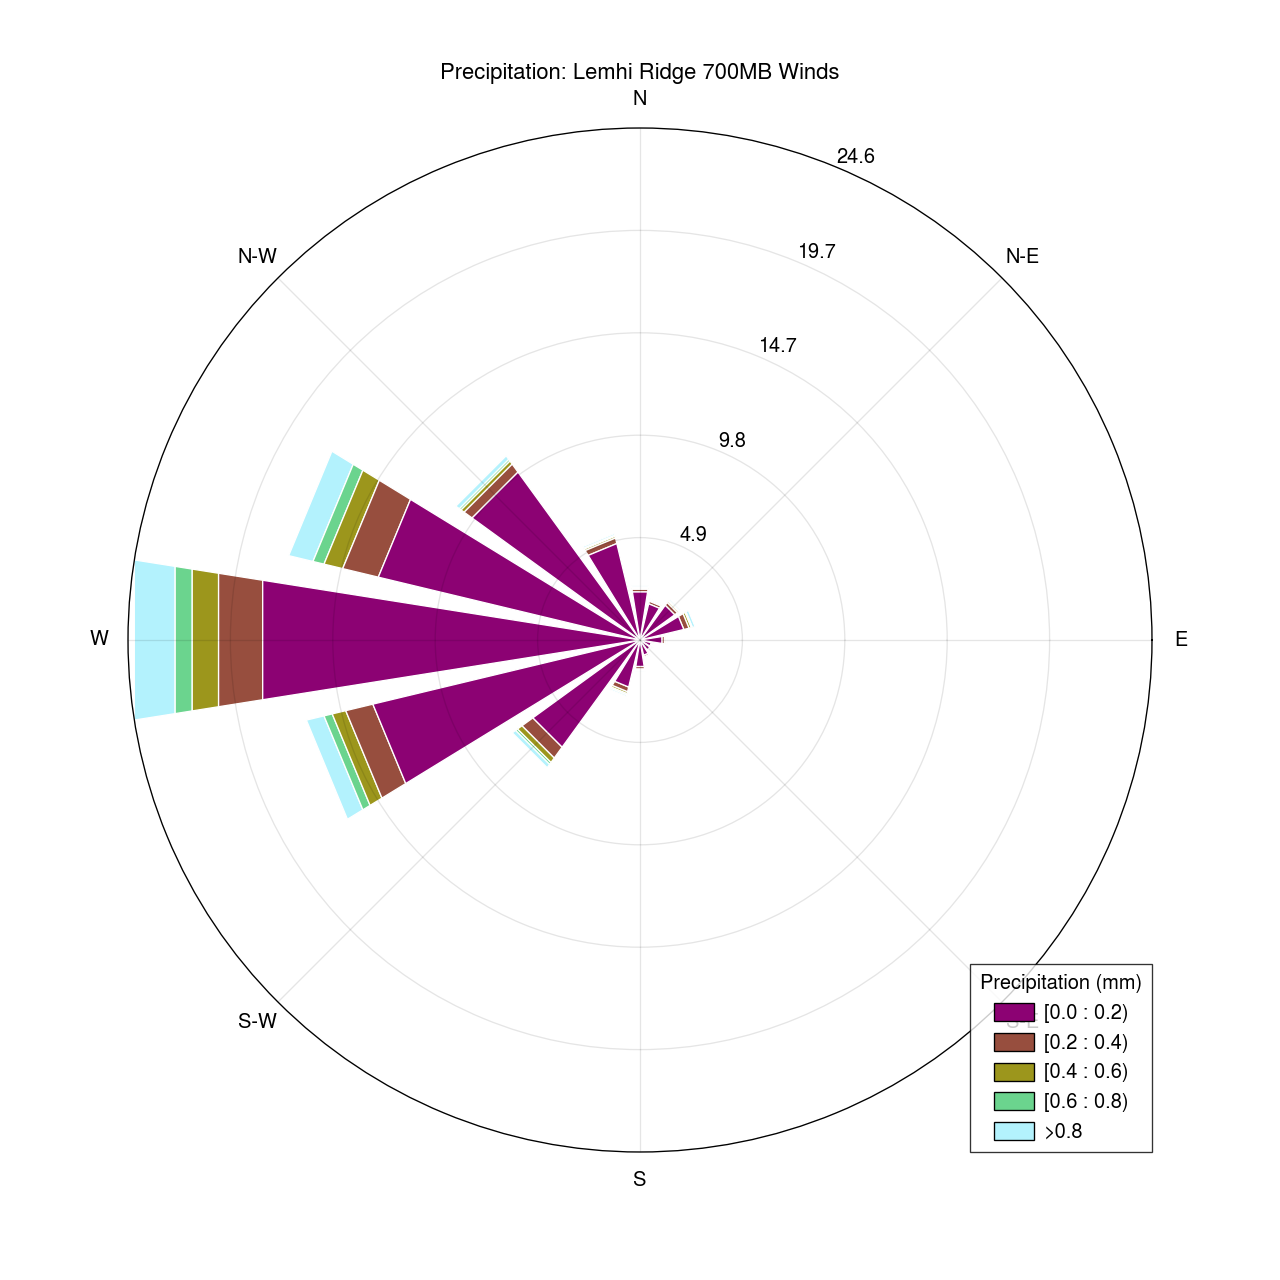

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Mule_Creek_700MB_Winds_Windrose.png"


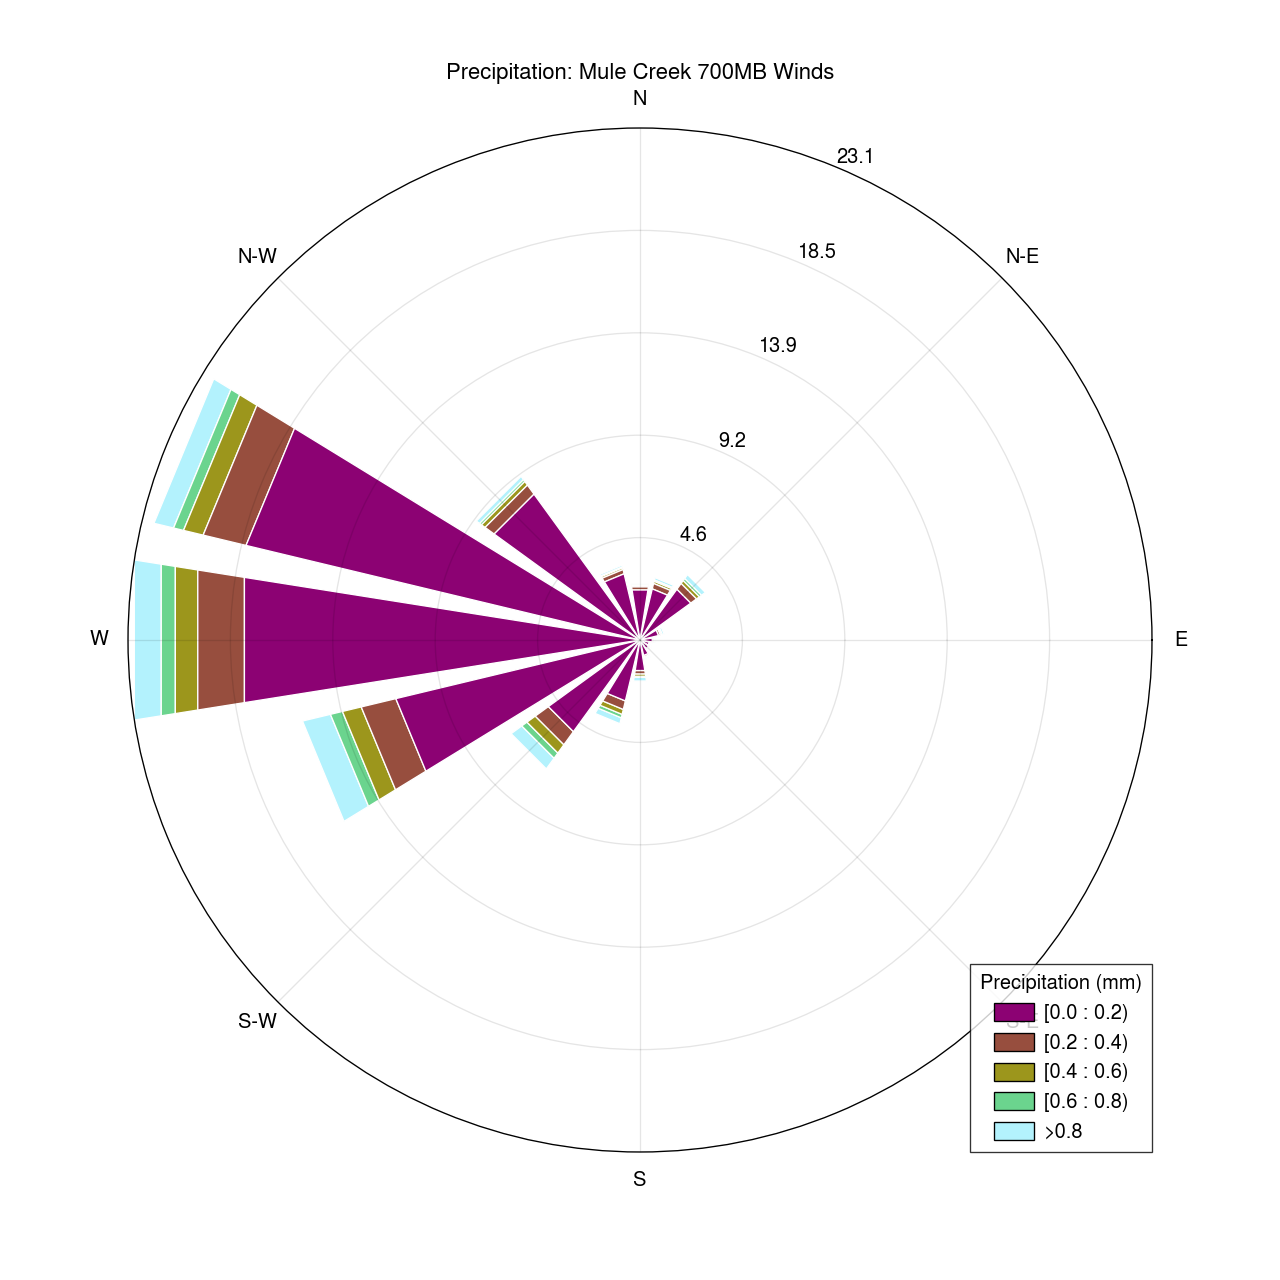

Saving windrose image to: "/Users/meghan/Montana/Montana_CONUS404/Windroses/precip_windrose/Precipitation_Saddle_Mountain_700MB_Winds_Windrose.png"


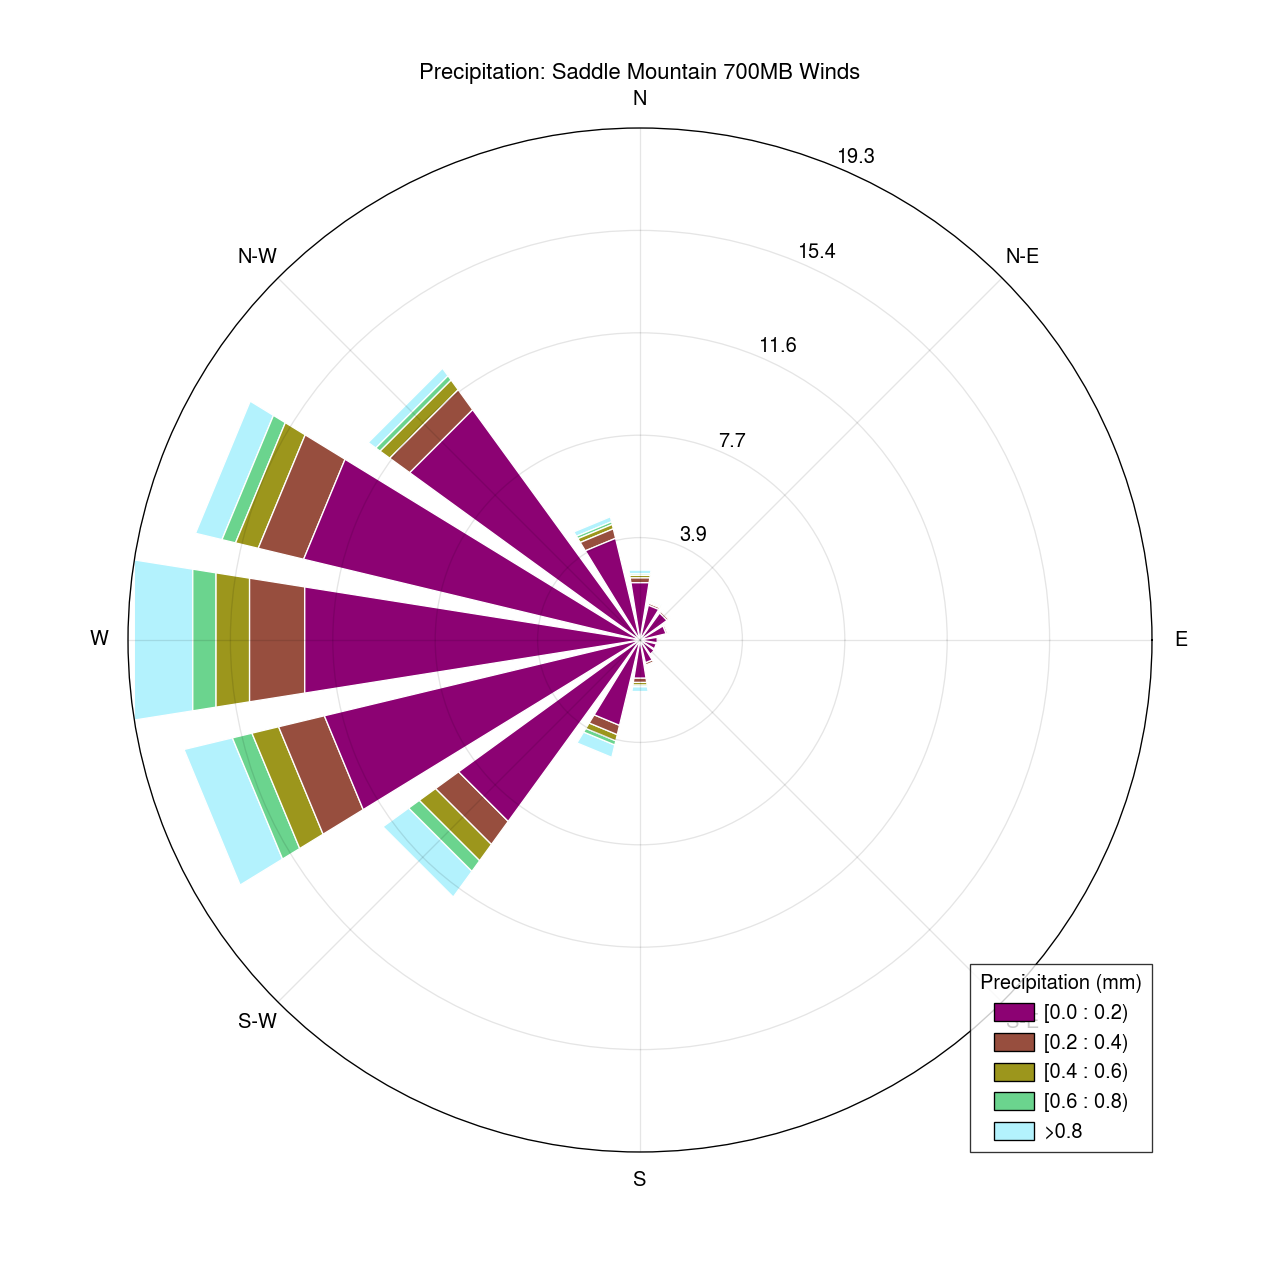

In [41]:
#Plot windroses by precipitation
def precip_windrose(filepath=None, name=None):
    filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
    ds = xr.open_dataset(filepath, engine = 'netcdf4')
    df = ds[['U_700MB','V_700MB','PREC_ACC_NC']].to_dataframe()
    df=df[df['PREC_ACC_NC']>0]
    df.U_700MB[df.U_700MB > 999] = np.nan
    df.V_700MB[df.V_700MB > 999] = np.nan
    df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
    df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
    df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    speed =df.WSPD
    dir = df.WDIR

    colormap = plt.get_cmap('hawaii')
    ax = WindroseAxes.from_ax()
    ax.bar(df.WDIR,df.PREC_ACC_NC, normed = True, opening=0.8, edgecolor='white', bins = np.arange(0,1,0.2),cmap = colormap)

    
    ax.set_legend()
    ax.set_title(name)
    ax.legend(title='Precipitation (mm)',loc = 4)

    # ax.set_yticks(np.arange(10, 40, step=10))
    # ax.set_yticklabels(np.arange(10, 40, step=10))

    # matplotlib.pyplot.savefig(os.path.join('precip_windrose',"{} Precip Windrose.png".format(name.replace(' ','_'))), dpi=300, transparent=False)
    #matplotlib.pyplot.close()output_name="{}_Windrose.png".format(name.replace('-','_').replace(':','').replace('(','').replace(')','').replace(' ','_'))
    output_name="{}_Windrose.png".format(name.replace('-','_').replace(':','').replace('(','').replace(')','').replace(' ','_'))
    output_file=os.path.join(output_path, 'precip_windrose', output_name)
    print(f'Saving windrose image to: "{output_file}"')
    matplotlib.pyplot.savefig(output_file, dpi=300, transparent=False)
    matplotlib.pyplot.show()
    
_=[precip_windrose(**dd) for dd in precipfiles]


In [ ]:
#Transparent Windrose
def precip_windrose(filepath=None, name=None):
    filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
    ds = xr.open_dataset(filepath, engine = 'netcdf4')
    df = ds[['U_700MB','V_700MB','PREC_ACC_NC']].to_dataframe()
    df=df[df['PREC_ACC_NC']>0]
    df.U_700MB[df.U_700MB > 999] = np.nan
    df.V_700MB[df.V_700MB > 999] = np.nan
    df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
    df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
    df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    speed =df.WSPD
    dir = df.WDIR

    colormap = plt.get_cmap('glacial')
    ax = WindroseAxes.from_ax()
    ax.bar(df.WDIR,df.WSPD, normed = True, opening=0.8, edgecolor='white', bins = 10,cmap = colormap)

    
    # ax.set_legend()
    ax.set_title(name)
    # ax.legend(title='Wind Speed (m/s))',loc = 4)

    # ax.set_yticks(np.arange(10, 40, step=10))
    # ax.set_yticklabels(np.arange(10, 40, step=10))

    #matplotlib.pyplot.savefig(os.path.join('precip_windrose',"{} Precip Windrose.png".format(name.replace(' ','_'))), dpi=300, transparent=False)
    #matplotlib.pyplot.close()
    matplotlib.pyplot.show()
    
_=[precip_windrose(**dd) for dd in files]


In [ ]:
#Data Files for Basin Windroses
files2=[
    
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/wr1.nc','name':'Wind Rose 1 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/wr2.nc','name':'Wind Rose 2 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/wr3.nc','name':'Wind Rose 3 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/wr4.nc','name':'Wind Rose 4 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/area_avgs/wr5.nc','name':'Wind Rose 5 700MB Winds'},
    {'filepath':'/Users/meghan/Montana/Montana_Masks/masks/windrosesites/wr6.nc','name':'Wind Rose 6 700MB Winds'},

 
    ]

In [ ]:
#Transparent Windrose
def basin_windrose(filepath=None, name=None):
    filepath = filepath if os.path.exists(filepath) else os.path.join('windrose_data', filepath)
    ds = xr.open_dataset(filepath, engine = 'netcdf4')
    df = ds[['U_700MB','V_700MB','PREC_ACC_NC']].to_dataframe()
    df=df[df['PREC_ACC_NC']>0]
    df.U_700MB[df.U_700MB > 999] = np.nan
    df.V_700MB[df.V_700MB > 999] = np.nan
    df['WSPD'] = np.sqrt(df.U_700MB**2+df.V_700MB**2)
    df['WDIR'] = np.arctan2(df.U_700MB.values,df.V_700MB.values)*180/math.pi+180;
    df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

    speed =df.WSPD
    dir = df.WDIR

    colormap = plt.get_cmap('glacial')
    ax = WindroseAxes.from_ax()
    ax.bar(df.WDIR,df.WSPD, normed = True, opening=0.8, edgecolor='white', bins = 10,cmap = colormap)

    
    # ax.set_legend()
    ax.set_title(name)
    # ax.legend(title='Wind Speed (m/s))',loc = 4)

    # ax.set_yticks(np.arange(10, 40, step=10))
    # ax.set_yticklabels(np.arange(10, 40, step=10))

    #matplotlib.pyplot.savefig(os.path.join('precip_windrose',"{} Precip Windrose.png".format(name.replace(' ','_'))), dpi=300, transparent=False)
    #matplotlib.pyplot.close()
    matplotlib.pyplot.show()
    
_=[basin_windrose(**dd) for dd in files2]
